In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple, Dict
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from sklearn.model_selection import KFold
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FuncFormatter

from __future__ import annotations
from collections import Counter
from dataclasses import dataclass
import hashlib

from going_modular import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 


from rpy2.robjects import Formula
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter
from rpy2.robjects import r
from rpy2.robjects import pandas2ri, conversion
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import DataFrame, FloatVector, IntVector, ListVector, Vector, StrVector

rstpm2 = importr("rstpm2")
survival = importr("survival")
ggplot2 = importr("ggplot2")
graphics = importr("graphics")
stats = importr("stats")
lmtest = importr("lmtest")

In [2]:
lical0 = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/DataFile/lical0_processed_data_for_fp_model_21-01-2026.csv')
miro0 = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/DataFile/miro0_processed_data_for_fp_model_21-01-2026.csv')
miroli0 = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/DataFile/miroli0_processed_data_for_fp_model_21-01-2026.csv')
ril_3010 = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/DataFile/ril_3010_processed_data_for_fp_model_21-01-2026.csv')
proact0 = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/DataFile/proact0_processed_data_for_fp_model_21-01-2026.csv')

In [3]:
miroli0.head(3)

,subject_id,Event,Disease_Duration,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS,Age_VC,Sex_VC,Onset_VC,Age_sq
0,P01001,0,32.600526,1,-0.355001,-0.075830,0.363265,0.828441,1,1,1,-0.355001,-0.355001,0.026920,-0.294097,0.828441,0.828441,0.126026
1,P01002,1,41.538765,1,0.255274,-1.168542,1.103061,0.398812,1,0,0,0.000000,0.255274,-0.298299,0.101806,0.000000,0.398812,0.065165
2,P01003,0,34.571616,0,-1.123785,-1.189109,0.616453,0.563821,1,1,1,-1.123785,-1.123785,1.336303,-0.633614,0.563821,0.563821,1.262893


In [4]:
lical0_pla = lical0[lical0['Study_Arm_Placebo'] == 1].copy()
miro0_pla = miro0[miro0['Study_Arm_Placebo'] == 1].copy()
miroli0_pla = miroli0[miroli0['Study_Arm_Placebo'] == 1].copy()
ril_3010_pla = ril_3010[ril_3010['Study_Arm_Placebo'] == 1].copy()
proact0_pla = proact0[proact0['Study_Arm_Placebo'] == 1].copy() 

In [5]:
lical0_trt = lical0[lical0['Study_Arm_Placebo'] == 0].copy()
miro0_trt = miro0[miro0['Study_Arm_Placebo'] == 0].copy()
miroli0_trt = miroli0[miroli0['Study_Arm_Placebo'] == 0].copy()
ril_3010_trt = ril_3010[ril_3010['Study_Arm_Placebo'] == 0].copy()
proact0_trt = proact0[proact0['Study_Arm_Placebo'] == 0].copy() 

In [6]:
ril_3010_pla.Study_Arm_Placebo.value_counts()

Study_Arm_Placebo
1    242
Name: count, dtype: int64

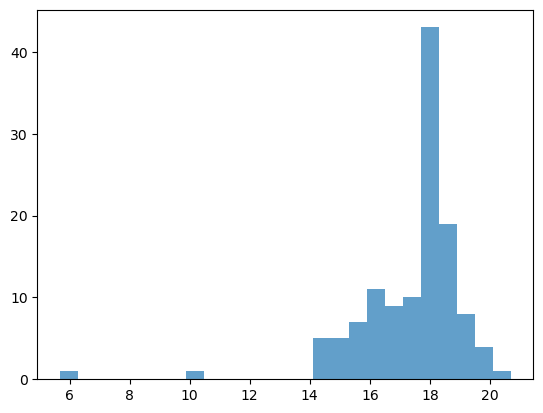

In [7]:
# histogram of disease duration
placebo_only = ril_3010_pla.loc[ril_3010_pla["Event"] == 0, ["Disease_Duration","Age"]]

plt.hist(placebo_only.Disease_Duration, bins=25, density=False, alpha=0.7)
plt.show()


In [8]:

# exclude the censored individuals with disease duration less than 14
ril_3010_pla = ril_3010_pla[~((ril_3010_pla["Event"] == 0) & (ril_3010_pla['Disease_Duration'] < 14))]

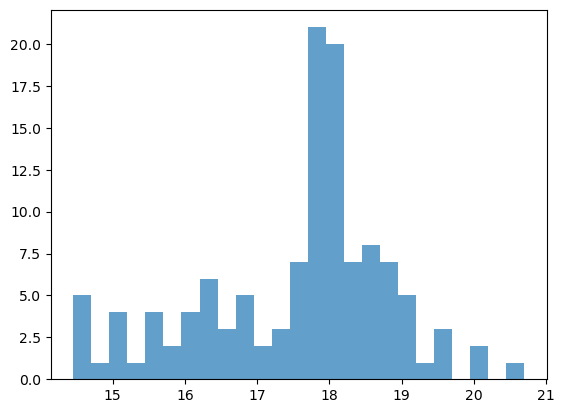

In [9]:
# histogram of disease duration
placebo_only = ril_3010_pla.loc[ril_3010_pla["Event"] == 0, ["Disease_Duration","Age"]]

plt.hist(placebo_only.Disease_Duration, bins=25, density=False, alpha=0.7)
plt.show()

In [10]:
ril_3010_pla.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 1 to 956
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         240 non-null    int64  
 1   Event              240 non-null    int64  
 2   Disease_Duration   240 non-null    float64
 3   Study_Arm_Placebo  240 non-null    int64  
 4   Age                240 non-null    float64
 5   TRICALS            240 non-null    float64
 6   Diagnostic_Delay   240 non-null    float64
 7   Vital_capacity     240 non-null    float64
 8   Onset_Limb         240 non-null    int64  
 9   Sex_Male           240 non-null    int64  
 10  Sex_onset          240 non-null    int64  
 11  Age_Sex            240 non-null    float64
 12  Age_onset          240 non-null    float64
 13  Age_TRICALS        240 non-null    float64
 14  Age_VC             240 non-null    float64
 15  Sex_VC             240 non-null    float64
 16  Onset_VC           240 non-null

## **Second attempt on Bootstrapping, calibration slope, regression coefficients, CI.**

In [11]:
# ============================================================
# HELPERS (DROP-IN): automatic direction detection + consistent
# scoring for C-index, slope, shrinkage, and reporting.
#
# Key conventions enforced:
#   - LP is extracted from stpm2 via type="lpmatrix" %*% coef
#   - A "risk score" is constructed so that:
#         mean(score | Event=1) > mean(score | Event=0)
#     i.e. higher score => higher hazard (worse prognosis)
#   - Concordance (Harrell's C) is computed using I(-score),
#     because survival::concordance assumes larger x => longer survival.
#   - Calibration slope is computed with score (higher => higher hazard).
#   - CITL at t0 is computed from predicted survival and KM; independent of score sign.
#
# These helpers are designed to eliminate all of the sign flip confusion
# you encountered (TRICALS changing the sign, etc.).
# ============================================================
# ============================================================
# R snippets setup

R = ro.r

# ---------- R snippets ----------
_r_conc_extract = R("""function(conc_obj) as.numeric(conc_obj$concordance[1])""")

# _r_predict_lp = R("""
# function(model, newdata){
#   X <- predict(model, newdata=newdata, type="lpmatrix")
#   b <- coef(model)
#   drop(X %*% b)
# }
# """)

_r_predict_surv_t0 = R("""
function(model, newdata, t0){
  n <- nrow(newdata)
  tmp <- transform(newdata, t0=rep(as.numeric(t0), n))
  as.numeric(predict(model, newdata=tmp, type="surv", timevar="t0"))
}
""")

_r_km_surv_t0 = R("""
function(df, t0){
  fit <- survival::survfit(survival::Surv(Disease_Duration, Event==1) ~ 1, data=df)
  ss <- summary(fit, times=as.numeric(t0))
  if(length(ss$surv)==0) return(NA_real_)
  as.numeric(ss$surv[1])
}
""")

_r_km_risk_ci_t0 = R("""
function(df, t0){
  fit <- survival::survfit(survival::Surv(Disease_Duration, Event==1) ~ 1, data=df)
  ss <- summary(fit, times=as.numeric(t0))
  if(length(ss$surv)==0) return(c(NA_real_, NA_real_, NA_real_))
  S  <- as.numeric(ss$surv[1])
  Lo <- as.numeric(ss$lower[1])
  Hi <- as.numeric(ss$upper[1])
  risk    <- 1 - S
  risk_lo <- 1 - Hi
  risk_hi <- 1 - Lo
  c(risk, risk_lo, risk_hi)
}
""")

# ============================================================
# Conversion helper
# ============================================================ full
def to_r_df(df: pd.DataFrame):
    with localconverter(default_converter + pandas2ri.converter):
        return pandas2ri.py2rpy(df)

# ============================================================
# LP / Score helpers
# ============================================================
# def predict_lp_stpm2(model, r_df) -> np.ndarray:
#     """Full linear predictor (includes baseline spline terms)."""
#     return np.asarray(_r_predict_lp(model, r_df), dtype=float)



def predict_pi_from_stpm2(model, r_df, vars_final: list[str]) -> np.ndarray:
    """
    Prognostic index PI(x) = x^T beta using ONLY covariate coefficients
    that match vars_final exactly.
    r_df must contain those columns as numeric.
    """
    coef_vec = ro.r["coef"](model)
    coef_names = list(map(str, ro.r["names"](coef_vec)))
    b = np.asarray(list(coef_vec), dtype=float)
    coef_map = dict(zip(coef_names, b))

    missing = [v for v in vars_final if v not in coef_map]
    if missing:
        raise ValueError(
            f"vars_final not found in coef(model): {missing}\n"
            f"First 40 coef names: {coef_names[:40]}"
        )

    # Extract X from r_df (as numpy)
    Xcols = []
    for v in vars_final:
        Xcols.append(np.asarray(r_df.rx2(v), dtype=float))
    X = np.column_stack(Xcols)  # n x p

    beta = np.asarray([coef_map[v] for v in vars_final], dtype=float)
    return X @ beta


def _event_mask_from_r(r_df, event_col: str = "Event") -> np.ndarray:
    """Extract Event vector from an R df and return boolean mask event==1."""
    ev = np.asarray(r_df.rx2(event_col), dtype=float)
    return (ev == 1)

def choose_score_sign_from_lp(
    lp: np.ndarray,
    event_mask: np.ndarray,
) -> int:
    """
    Decide whether score should be LP (+1) or -LP (-1)
    so that mean(score|event=1) > mean(score|event=0).
    Returns sign s in {+1, -1} such that score = s * lp.
    """
    lp = np.asarray(lp, float)
    m1 = float(np.mean(lp[event_mask])) if np.any(event_mask) else np.nan
    m0 = float(np.mean(lp[~event_mask])) if np.any(~event_mask) else np.nan

    # If either group missing, default to +1 (no flip) but warn by returning +1
    if not np.isfinite(m1) or not np.isfinite(m0):
        return +1

    # Want score higher in event group. If lp already higher in events => +1 else -1
    return +1 if (m1 > m0) else -1

# def risk_score_stpm2(
#     model,
#     r_df, 
#     vars_final: list[str],
#     event_col: str = "Event",
#     sign: int | None = None,
#     return_details: bool = False,
# ):
#     """
#     Compute risk score for a fitted stpm2 model with automatic sign detection.

#     - score is constructed so higher = worse (higher hazard):
#         mean(score | Event=1) > mean(score | Event=0)

#     If sign is provided (+1 or -1), it is used directly (no detection).

#     Returns:
#       score (np.ndarray)
#     Optionally returns details dict with lp means and chosen sign.
#     """
#     lp = predict_pi_from_stpm2(model, r_df, vars_final=vars_final)
#     event_mask = _event_mask_from_r(r_df, event_col=event_col)

#     if sign is None:
#         sign = choose_score_sign_from_lp(lp, event_mask)

#     score = sign * lp

#     if not return_details:
#         return score

#     m1_lp = float(np.mean(lp[event_mask])) if np.any(event_mask) else np.nan
#     m0_lp = float(np.mean(lp[~event_mask])) if np.any(~event_mask) else np.nan
#     m1_sc = float(np.mean(score[event_mask])) if np.any(event_mask) else np.nan
#     m0_sc = float(np.mean(score[~event_mask])) if np.any(~event_mask) else np.nan

#     return score, {
#         "chosen_sign": int(sign),
#         "mean_lp_event1": m1_lp,
#         "mean_lp_event0": m0_lp,
#         "mean_score_event1": m1_sc,
#         "mean_score_event0": m0_sc,
#     }


def risk_score_stpm2(
    model,
    r_df,
    vars_final: list[str],          # <-- REQUIRED NOW
    event_col: str = "Event",
    sign: int | None = None,
    return_details: bool = False,
):
    """
    Risk score based on PI(x)=x^T beta (covariates only, no baseline spline leakage).
    Higher score => higher hazard (worse).
    """
    pi = predict_pi_from_stpm2(model, r_df, vars_final=vars_final)
    event_mask = _event_mask_from_r(r_df, event_col=event_col)

    if sign is None:
        sign = choose_score_sign_from_lp(pi, event_mask)  # same logic, now applied to PI

    score = sign * pi

    if not return_details:
        return score

    m1_pi = float(np.mean(pi[event_mask])) if np.any(event_mask) else np.nan
    m0_pi = float(np.mean(pi[~event_mask])) if np.any(~event_mask) else np.nan
    m1_sc = float(np.mean(score[event_mask])) if np.any(event_mask) else np.nan
    m0_sc = float(np.mean(score[~event_mask])) if np.any(~event_mask) else np.nan

    return score, {
        "chosen_sign": int(sign),
        "mean_pi_event1": m1_pi,
        "mean_pi_event0": m0_pi,
        "mean_score_event1": m1_sc,
        "mean_score_event0": m0_sc,
    }

# ============================================================
# Performance metrics (direction-safe)
# ============================================================
def cindex_from_risk_score(r_df, score: np.ndarray) -> float:
    """
    Harrell's C computed consistently.
    survival::concordance assumes larger x => longer survival, so use -score.
    """
    r_tmp = R("transform")(r_df, score=FloatVector(np.asarray(score, float).tolist()))
    conc_obj = survival.concordance(
        Formula("Surv(Disease_Duration, Event==1) ~ I(-score)"),
        data=r_tmp
    )
    return float(_r_conc_extract(conc_obj)[0])

def slope_from_risk_score(r_df, score: np.ndarray) -> float:
    """
    Calibration slope via Cox model using risk score (higher => higher hazard).
    """
    r_tmp = R("transform")(r_df, score=FloatVector(np.asarray(score, float).tolist()))
    cal = survival.coxph(
        Formula("Surv(Disease_Duration, Event==1) ~ score"),
        data=r_tmp
    )
    return float(np.asarray(R["coef"](cal), dtype=float)[0])

# ============================================================
# CITL and survival-at-t0 (sign independent)
# ============================================================
def predict_surv_at_t0(model, r_df, t0_months: float) -> np.ndarray:
    return np.asarray(_r_predict_surv_t0(model, r_df, float(t0_months)), dtype=float)

def _logit(p: float) -> float:
    p = float(np.clip(p, 1e-12, 1-1e-12))
    return float(np.log(p/(1-p)))

def km_surv_at_t0(r_df, t0_months: float) -> float:
    return float(_r_km_surv_t0(r_df, float(t0_months))[0])

def citl_at_t0(model, r_df, t0_months: int) -> float:
    """
    CITL(t0) = logit(p_obs(t0)) - logit(mean(p_pred(t0)))
    p_pred(t0) = 1 - S_pred(t0)
    p_obs(t0)  = 1 - S_KM(t0)
    """
    S_pred = predict_surv_at_t0(model, r_df, t0_months)
    p_pred = 1.0 - S_pred
    p_bar = float(np.mean(p_pred))

    S_km = km_surv_at_t0(r_df, t0_months)
    if not np.isfinite(S_km):
        return np.nan
    p_obs = 1.0 - float(S_km)
    return float(_logit(p_obs) - _logit(p_bar))

# ============================================================
# Shrinkage helper (valid only when slope_corr > 0)
# ============================================================
def uniform_shrinkage_from_slope(slope_corr: float) -> float:
    """
    Uniform shrinkage factor s = min(1, 1/slope_corr)
    - If slope_corr < 1 => underfitting / conservative -> s = 1 (no shrinkage)
    - If slope_corr > 1 => overfitting -> shrink (s < 1)
    """
    if not np.isfinite(slope_corr) or slope_corr <= 0:
        # sign errors should not happen if score sign detection is used,
        # but keep a safe fallback.
        return 1.0
    return float(min(1.0, 1.0 / slope_corr))

# ============================================================
# Convenience: evaluate a fitted stpm2 model on a dataset
# (apparent metrics; fully direction-safe)
# ============================================================
def evaluate_stpm2_apparent(
    model,
    r_df,
    t0_months: int = 24,
    event_col: str = "Event",
    sign: int | None = None,   # optional: fix sign for comparability
    verbose: bool = True,
):
    score, info = risk_score_stpm2(model, r_df, event_col=event_col, sign=sign, return_details=True)

    c = cindex_from_risk_score(r_df, score)
    s = slope_from_risk_score(r_df, score)
    citl = citl_at_t0(model, r_df, t0_months)

    if verbose:
        print("Score sign chosen:", info["chosen_sign"])
        print("Mean LP event=1 / event=0:", info["mean_lp_event1"], info["mean_lp_event0"])
        print("Mean score event=1 / event=0:", info["mean_score_event1"], info["mean_score_event0"])
        print("C-index:", c)
        print("Slope:", s)
        print("CITL:", citl)

    return {"cindex": c, "slope": s, "citl": citl, "score_sign": info["chosen_sign"], "details": info}

# ============================================================
# (Optional) Calibration bins utility (KM risk with CI)
# ============================================================
def km_risk_ci_at_t0(r_df_sub, t0_months: int) -> tuple[float, float, float]:
    out = np.asarray(_r_km_risk_ci_t0(r_df_sub, float(t0_months)), dtype=float)
    if np.any(~np.isfinite(out)):
        return (np.nan, np.nan, np.nan)
    return (float(out[0]), float(out[1]), float(out[2]))

def calibration_bins_km(r_df, pred_risk: np.ndarray, t0_months: int, n_bins: int = 5) -> pd.DataFrame:
    df = pd.DataFrame({"pred": np.asarray(pred_risk, float)})
    df["bin"] = pd.qcut(df["pred"], q=n_bins, duplicates="drop")

    rows = []
    for b in df["bin"].cat.categories:
        mask = (df["bin"] == b).to_numpy()
        idx0 = np.where(mask)[0]
        if len(idx0) == 0:
            continue
        r_sub = r_df.rx(IntVector((idx0 + 1).tolist()), True)
        risk, lo, hi = km_risk_ci_at_t0(r_sub, t0_months)
        if not np.isfinite(risk):
            continue
        rows.append({
            "bin": str(b),
            "n": int(mask.sum()),
            "mean_pred": float(df.loc[mask, "pred"].mean()),
            "obs_km": float(risk),
            "obs_lo": float(lo),
            "obs_hi": float(hi),
        })
    return pd.DataFrame(rows)

# ============================================================
# QUICK USAGE EXAMPLE (after you fit model_best_full)
# ============================================================
# with localconverter(default_converter + pandas2ri.converter):
#     r_full = pandas2ri.py2rpy(dev_df)
#
# out = evaluate_stpm2_apparent(model_best_full, r_full, t0_months=24, verbose=True)
# ============================================================

# ============================================================
# FULL-STRATEGY BOOTSTRAP VALIDATION (CORRECTED)
# ------------------------------------------------------------
# - Repeats the *entire* modelling strategy inside each bootstrap:
#     * backward AIC selection (with forced include/exclude)
#     * baseline spline df selection (over df_candidates)
# - Uses automatic direction detection for the risk score:
#     * score = s * LP, where s ∈ {+1, -1} chosen so that
#           mean(score | Event=1) > mean(score | Event=0)
# - FIXES SIGN CONSISTENCY:
#     * sign is chosen ON THE BOOTSTRAP SAMPLE (in-sample)
#     * the SAME sign is used when evaluating OUT-OF-BOOTSTRAP
#       on the original full dataset (no re-detection)
# - Computes optimism-corrected:
#     * C-index (via concordance with I(-score))
#     * Calibration slope (Cox on score)
#     * CITL at t0 (from predicted survival & KM)
#
# Requires your previously pasted helpers:
#   - backward_elimination_aic (SelectionResult)
#   - to_r_df
#   - risk_score_stpm2 (with sign optional)
#   - cindex_from_risk_score
#   - slope_from_risk_score
#   - citl_at_t0
#
# And assumes: rstpm2, survival, stats are available.
# ============================================================

from __future__ import annotations
from dataclasses import dataclass
from collections import Counter
import numpy as np
import hashlib

import rpy2.robjects as ro
from rpy2.robjects import Formula

R = ro.r

@dataclass
class FullStrategyValidationResult:
    best_vars_full: list[str]
    best_spline_df_full: int
    best_aic_full: float
    best_formula_full: str

    cindex_app: float
    slope_app: float
    citl_app: float

    cindex_corr: float
    slope_corr: float
    citl_corr: float

    cindex_ci: tuple[float, float]
    slope_ci: tuple[float, float]
    citl_ci: tuple[float, float]

    n_boot_success: int
    n_boot_fail: int

def _model_signature(vars_list: list[str], spline_df: int) -> str:
    key = f"df={spline_df}|" + "+".join(vars_list)
    return hashlib.md5(key.encode("utf-8")).hexdigest()

def backward_elimination_aic(
    df_python: pd.DataFrame,
    covariates: list[str],
    df_candidates: list[int],
    hard_include: list[str],
    hard_exclude: list[str] | None = None,
) -> SelectionResult:
    hard_exclude = list(hard_exclude or [])

    start_vars = [v for v in covariates if v not in set(hard_exclude)]
    for v in hard_include:
        if v not in start_vars and v not in set(hard_exclude):
            start_vars.append(v)

    forced = set(hard_include)
    r_df = _to_r_df(df_python.reset_index(drop=True))
    current_vars = start_vars[:]
    best: SelectionResult | None = None

    def better(a: SelectionResult, b: SelectionResult | None) -> bool:
        if b is None:
            return True
        return a.aic < b.aic - 1e-12

    while len(current_vars) >= 1:
        candidates: list[SelectionResult] = []

        for ddf in df_candidates:
            _, aic, fml = fit_stpm2_and_aic(r_df, current_vars, ddf)
            candidates.append(SelectionResult(current_vars[:], ddf, aic, fml))

        removable = [v for v in current_vars if v not in forced]
        for var in removable:
            test_vars = [v for v in current_vars if v != var]
            if not test_vars:
                continue
            for ddf in df_candidates:
                _, aic, fml = fit_stpm2_and_aic(r_df, test_vars, ddf)
                candidates.append(SelectionResult(test_vars[:], ddf, aic, fml))

        cand_best = None
        for c in candidates:
            if better(c, cand_best):
                cand_best = c

        if cand_best is None:
            break
        if best is not None and cand_best.aic >= best.aic - 1e-12:
            break

        best = cand_best
        current_vars = best.vars_final[:]
        if all(v in forced for v in current_vars):
            break

    if best is None:
        forced_list = [v for v in hard_include if v not in set(hard_exclude)]
        ddf = df_candidates[0]
        _, aic, fml = fit_stpm2_and_aic(r_df, forced_list, ddf)
        best = SelectionResult(forced_list, ddf, aic, fml)

    return best


def full_strategy_bootstrap_validation_corrected(
    df_full: pd.DataFrame,
    covariates: list[str],
    df_candidates: list[int],
    hard_include: list[str],
    hard_exclude: list[str] | None,
    t0_months: int,
    n_boot: int,
    random_state: int | None = None,
    event_col: str = "Event",
    verbose: bool = True,
):
    """
    Returns:
      res (FullStrategyValidationResult)
      diag (dict) with inclusion frequencies and selected df/model counts
      model_best_full (fitted stpm2 on full data using the chosen strategy)
    """
    hard_exclude = list(hard_exclude or [])
    rng = np.random.default_rng(random_state)

    df_full = df_full.reset_index(drop=True).copy()
    r_full = to_r_df(df_full)

    # ---------- Best model on full data (same selection strategy) ----------
    sel_full = backward_elimination_aic(
        df_python=df_full,
        covariates=covariates,
        df_candidates=df_candidates,
        hard_include=hard_include,
        hard_exclude=hard_exclude,
    )
    model_best_full = rstpm2.stpm2(Formula(sel_full.formula), data=r_full, df=sel_full.spline_df)

    # Apparent performance on full data:
    # IMPORTANT: sign is detected on the full data for the apparent score.
    # score_full, info_full = risk_score_stpm2(
    #     model_best_full, r_full, event_col=event_col, sign=None, return_details=True
    # )

    score_full, info_full = risk_score_stpm2(
    model_best_full, r_full,
    vars_final=sel_full.vars_final,
    event_col=event_col,
    sign=None,
    return_details=True)

    c_app = cindex_from_risk_score(r_full, score_full)
    s_app = slope_from_risk_score(r_full, score_full)
    citl_app = citl_at_t0(model_best_full, r_full, t0_months)

    if verbose:
        print("\n[Apparent] score sign on FULL data:", info_full["chosen_sign"])
        print("[Apparent] mean LP event1/event0:", info_full["mean_pi_event1"], info_full["mean_pi_event0"])
        print("[Apparent] mean score event1/event0:", info_full["mean_score_event1"], info_full["mean_score_event0"])

    # ---------- Bootstrap loops (full strategy) ----------
    n = len(df_full)
    c_diffs, s_diffs, citl_diffs = [], [], []
    c_out_list, s_out_list, citl_out_list = [], [], []

    boot_coefs = []   # NEW: store coef vectors for final model only


    incl_counts = Counter()
    df_counts = Counter()
    model_counts = Counter()

    n_success = 0
    n_fail = 0

    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)
        df_boot = df_full.iloc[idx].reset_index(drop=True)

        try:
            # (1) Repeat selection strategy within bootstrap
            sel_boot = backward_elimination_aic(
                df_python=df_boot,
                covariates=covariates,
                df_candidates=df_candidates,
                hard_include=hard_include,
                hard_exclude=hard_exclude,
            )
            incl_counts.update(sel_boot.vars_final)
            df_counts.update([sel_boot.spline_df])
            model_counts.update([_model_signature(sel_boot.vars_final, sel_boot.spline_df)])

            # (2) Fit the selected model in bootstrap sample
            r_boot = to_r_df(df_boot)
            model_boot = rstpm2.stpm2(Formula(sel_boot.formula), data=r_boot, df=sel_boot.spline_df)

            # --- store bootstrap coefficients ONLY if model structure matches final model ---
            if (
                sel_boot.vars_final == sel_full.vars_final and
                sel_boot.spline_df == sel_full.spline_df
            ):
                bvec = np.asarray(list(ro.r["coef"](model_boot)), dtype=float)
                boot_coefs.append(bvec)


            # (3) IN-sample evaluation (bootstrap)
            # Detect sign ON BOOTSTRAP SAMPLE
            # score_in, info_in = risk_score_stpm2(
            #     model_boot, r_boot, event_col=event_col, sign=None, return_details=True
            # )

            score_in, info_in = risk_score_stpm2(
                model_boot, r_boot,
                vars_final=sel_boot.vars_final,
                event_col=event_col,
                sign=None,
                return_details=True
            )

            sign_boot = info_in["chosen_sign"]

            c_in = cindex_from_risk_score(r_boot, score_in)
            s_in = slope_from_risk_score(r_boot, score_in)
            citl_in = citl_at_t0(model_boot, r_boot, t0_months)

            # (4) OUT-of-sample evaluation (original full data)
            # FIX SIGN CONSISTENCY: re-use sign_boot, DO NOT re-detect on full data
            # score_out = risk_score_stpm2(
            #     model_boot, r_full, event_col=event_col, sign=sign_boot, return_details=False
            # )

            score_out = risk_score_stpm2(
                model_boot, r_full,
                vars_final=sel_boot.vars_final,
                event_col=event_col,
                sign=sign_boot,
                return_details=False
            )

            c_out = cindex_from_risk_score(r_full, score_out)
            s_out = slope_from_risk_score(r_full, score_out)
            citl_out = citl_at_t0(model_boot, r_full, t0_months)

            c_diffs.append(c_in - c_out)
            s_diffs.append(s_in - s_out)
            citl_diffs.append(citl_in - citl_out)

            c_out_list.append(c_out)
            s_out_list.append(s_out)
            citl_out_list.append(citl_out)

            n_success += 1

        except Exception:
            n_fail += 1

    # ---------- Optimism correction ----------
    if n_success > 0:
        c_corr = c_app - float(np.nanmean(c_diffs))
        s_corr = s_app - float(np.nanmean(s_diffs))
        citl_corr = citl_app - float(np.nanmean(citl_diffs))

        c_ci = tuple(np.nanpercentile(c_out_list, [2.5, 97.5]).astype(float))
        s_ci = tuple(np.nanpercentile(s_out_list, [2.5, 97.5]).astype(float))
        citl_ci = tuple(np.nanpercentile(citl_out_list, [2.5, 97.5]).astype(float))
    else:
        c_corr, s_corr, citl_corr = c_app, s_app, citl_app
        c_ci = (np.nan, np.nan)
        s_ci = (np.nan, np.nan)
        citl_ci = (np.nan, np.nan)

    denom = max(1, n_success)
    universe = (set(covariates) | set(hard_include)) - set(hard_exclude)
    incl_freq = {v: incl_counts[v] / denom for v in universe}

    res = FullStrategyValidationResult(
        best_vars_full=sel_full.vars_final,
        best_spline_df_full=int(sel_full.spline_df),
        best_aic_full=float(sel_full.aic),
        best_formula_full=sel_full.formula,

        cindex_app=float(c_app),
        slope_app=float(s_app),
        citl_app=float(citl_app),

        cindex_corr=float(c_corr),
        slope_corr=float(s_corr),
        citl_corr=float(citl_corr),

        cindex_ci=(float(c_ci[0]), float(c_ci[1])),
        slope_ci=(float(s_ci[0]), float(s_ci[1])),
        citl_ci=(float(citl_ci[0]), float(citl_ci[1])),

        n_boot_success=int(n_success),
        n_boot_fail=int(n_fail),
    )

    diag = {
        "selection_inclusion_counts": incl_counts,
        "selection_inclusion_freq": incl_freq,
        "selected_df_counts": df_counts,
        "selected_model_counts": model_counts,
        "n_boot_success": n_success,
        "n_boot_fail": n_fail,
        "apparent_score_sign_full": info_full["chosen_sign"],
    }

    if verbose:
        print("\nBootstrap reps success/fail:", n_success, n_fail)
        top = sorted(incl_freq.items(), key=lambda kv: kv[1], reverse=True)
        print("\nTop inclusion frequencies:")
        for v, f in top[:10]:
            print(f"  {v}: {f:.2f}")

    return res, diag, model_best_full, boot_coefs




# ============================================================
# ADD-ON: SUMMARY TABLES (CI in separate column) + COEFFICIENT TABLE
#         (non-updated vs updated/shrunk) + CALIBRATION PLOTS
#
# Assumes you already ran the previous "RUN ALL" cell and you have:
#   res_strategy, model_best_full, res_ext, shrinkage
#
# Notes:
# - "Updated coefficients" here = uniform-shrinkage updated coefficients (beta * shrinkage).
#   Baseline updating at t0 changes ONLY the baseline (absolute risk), not betas.
# - Coefficient CIs:
#     * Non-updated: Wald CI from stpm2 vcov (fast, standard)
#     * Updated/shrunk: Wald CI scaled by shrinkage (approximation, commonly used)
#
# - Plots: calibration (frozen vs baseline-updated) with KM Greenwood CI error bars.
# ============================================================



# ----------------------------
# Helper: format CI into separate column
# ----------------------------
def ci_str(lo, hi, digits=3):
    if lo is None or hi is None or (not np.isfinite(lo)) or (not np.isfinite(hi)):
        return ""
    return f"[{lo:.{digits}f}, {hi:.{digits}f}]"

# ----------------------------
# Summary table for INTERNAL (strategy) results
# CI is a separate column
# ----------------------------
def make_strategy_summary_table(res_strategy, t0_months: int) -> pd.DataFrame:
    rows = []
    def add(metric, value=None, lo=None, hi=None, digits=3):
        if isinstance(value, (float, int, np.floating)) and value is not None and np.isfinite(value):
            v = f"{float(value):.{digits}f}"
        else:
            v = value
        rows.append({"Metric": metric, "Value": v, "95% CI": ci_str(lo, hi, digits=digits)})

    add("Best model on full data (strategy)", ", ".join(res_strategy.best_vars_full))
    add("Best spline df on full data", res_strategy.best_spline_df_full, digits=0)
    add("AIC (best on full data)", res_strategy.best_aic_full)

    add("C-index (apparent, best model)", res_strategy.cindex_app)
    add("C-index (optimism-corrected, strategy)", res_strategy.cindex_corr,
        res_strategy.cindex_ci[0], res_strategy.cindex_ci[1])

    add("Calibration slope (apparent, best model)", res_strategy.slope_app)
    add("Calibration slope (optimism-corrected, strategy)", res_strategy.slope_corr,
        res_strategy.slope_ci[0], res_strategy.slope_ci[1])

    add(f"CITL at {t0_months} months (apparent, best model)", res_strategy.citl_app)
    add(f"CITL at {t0_months} months (optimism-corrected, strategy)", res_strategy.citl_corr,
        res_strategy.citl_ci[0], res_strategy.citl_ci[1])

    add("Bootstrap reps (success)", res_strategy.n_boot_success, digits=0)
    add("Bootstrap reps (fail)", res_strategy.n_boot_fail, digits=0)

    return pd.DataFrame(rows, columns=["Metric", "Value", "95% CI"])

# ----------------------------
# Summary table for EXTERNAL results (CI column included where applicable)
# For external: we typically don't have CI for c-index/slope here (unless bootstrapped externally).
# But calibration bins already contain KM CIs; we keep those in the calibration tables.
# ----------------------------
def make_external_summary_table(res_ext, t0_months: int) -> pd.DataFrame:
    rows = []
    def add(metric, value=None, lo=None, hi=None, digits=3):
        if isinstance(value, (float, int, np.floating)) and value is not None and np.isfinite(value):
            v = f"{float(value):.{digits}f}"
        else:
            v = value
        rows.append({"Metric": metric, "Value": v, "95% CI": ci_str(lo, hi, digits=digits)})

    add("External time horizon (months)", t0_months, digits=0)
    add("Model variables", ", ".join(res_ext.get("vars_final", [])))
    add("Shrinkage factor (uniform)", res_ext.get("shrinkage", np.nan))

    add("C-index (external)", res_ext.get("cindex_external", np.nan))
    add("Calibration slope (external)", res_ext.get("slope_external", np.nan))

    add("Observed KM survival at t0", res_ext.get("S_obs_km", np.nan))
    add("Observed KM risk at t0", res_ext.get("obs_risk_km", np.nan))

    add("Mean predicted risk at t0 (frozen)", res_ext.get("mean_pred_risk_frozen", np.nan))
    add("Baseline update factor", res_ext.get("baseline_factor", np.nan))
    add("Mean predicted risk at t0 (baseline-updated)", res_ext.get("mean_pred_risk_updated", np.nan))

    return pd.DataFrame(rows, columns=["Metric", "Value", "95% CI"])

# ----------------------------
# Coefficient table: non-updated (apparent) + updated (shrunken)
# Wald CI from stpm2 vcov, then scale by shrinkage for the updated CI
# ----------------------------
def coef_table_apparent_and_shrunk(model_best_full, vars_final: list[str], shrinkage: float) -> pd.DataFrame:
    # coefficients and vcov from R
    coef_vec = ro.r["coef"](model_best_full)
    vc = ro.r["vcov"](model_best_full)

    names = list(ro.r["names"](coef_vec))
    b = np.asarray(list(coef_vec), dtype=float)

    # Map name->index
    idx = {str(n): i for i, n in enumerate(names)}

    # Convert vcov to numpy
    vc_np = np.asarray(vc, dtype=float)

    rows = []
    for v in vars_final:
        if v not in idx:
            # if you ever move binaries to factors, you'd handle mapping here
            rows.append({
                "Variable": v,
                "Beta (apparent)": "",
                "95% CI (apparent)": "",
                "Beta (updated/shrunk)": "",
                "95% CI (updated/shrunk)": "",
            })
            continue

        i = idx[v]
        beta = float(b[i])
        se = float(np.sqrt(vc_np[i, i])) if np.isfinite(vc_np[i, i]) else np.nan

        lo = beta - 1.96 * se
        hi = beta + 1.96 * se

        beta_s = float(beta * shrinkage)
        lo_s = float(lo * shrinkage)
        hi_s = float(hi * shrinkage)

        rows.append({
            "Variable": v,
            "Beta (apparent)": f"{beta:.3f}",
            "95% CI (apparent)": ci_str(lo, hi, digits=3),
            "Beta (updated/shrunk)": f"{beta_s:.3f}",
            "95% CI (updated/shrunk)": ci_str(lo_s, hi_s, digits=3),
        })

    return pd.DataFrame(rows)



def coef_table_apparent_and_shrunk_2(
    model_best_full,
    vars_final: list[str],
    shrinkage: float,
    digits_beta: int = 3,
    digits_hr: int = 3,
) -> pd.DataFrame:
    """
    Build coefficient table for selected covariates from an stpm2 model:
      - log(HR) (beta) apparent with 95% CI
      - HR apparent with 95% CI
      - log(HR) updated/shrunk with 95% CI
      - HR updated/shrunk with 95% CI

    Assumes covariate term names in coef(model) match vars_final exactly
    (i.e., numeric 0/1 binaries, not factor-expanded names).
    """

    def ci_str(lo, hi, digits=3):
        if lo is None or hi is None or (not np.isfinite(lo)) or (not np.isfinite(hi)):
            return ""
        return f"[{lo:.{digits}f}, {hi:.{digits}f}]"

    def fmt(x, d):
        return "" if (x is None or (isinstance(x, float) and not np.isfinite(x))) else f"{float(x):.{d}f}"

    # coefficients and vcov from R
    coef_vec = ro.r["coef"](model_best_full)
    vc = ro.r["vcov"](model_best_full)

    names = list(ro.r["names"](coef_vec))
    b = np.asarray(list(coef_vec), dtype=float)

    # Map name->index
    idx = {str(n): i for i, n in enumerate(names)}

    # Convert vcov to numpy
    vc_np = np.asarray(vc, dtype=float)

    rows = []
    for v in vars_final:
        if v not in idx:
            rows.append({
                "Variable": v,

                "log(HR) apparent": "",
                "95% CI log(HR) apparent": "",
                "HR apparent": "",
                "95% CI HR apparent": "",

                "log(HR) shrunk": "",
                "95% CI log(HR) shrunk": "",
                "HR shrunk": "",
                "95% CI HR shrunk": "",
            })
            continue

        i = idx[v]
        beta = float(b[i])
        var_i = float(vc_np[i, i]) if np.isfinite(vc_np[i, i]) else np.nan
        se = float(np.sqrt(var_i)) if np.isfinite(var_i) and var_i >= 0 else np.nan

        # Apparent CI on log-HR scale
        lo = beta - 1.96 * se if np.isfinite(se) else np.nan
        hi = beta + 1.96 * se if np.isfinite(se) else np.nan

        # HR scale (exp)
        hr = float(np.exp(beta))
        hr_lo = float(np.exp(lo)) if np.isfinite(lo) else np.nan
        hr_hi = float(np.exp(hi)) if np.isfinite(hi) else np.nan

        # Shrunk (uniform shrinkage on beta & its CI on log scale)
        beta_s = float(beta * shrinkage)
        lo_s = float(lo * shrinkage) if np.isfinite(lo) else np.nan
        hi_s = float(hi * shrinkage) if np.isfinite(hi) else np.nan

        hr_s = float(np.exp(beta_s))
        hr_s_lo = float(np.exp(lo_s)) if np.isfinite(lo_s) else np.nan
        hr_s_hi = float(np.exp(hi_s)) if np.isfinite(hi_s) else np.nan

        rows.append({
            "Variable": v,

            "log(HR) apparent": fmt(beta, digits_beta),
            "95% CI log(HR) apparent": ci_str(lo, hi, digits=digits_beta),
            "HR apparent": fmt(hr, digits_hr),
            "95% CI HR apparent": ci_str(hr_lo, hr_hi, digits=digits_hr),

            "log(HR) shrunk": fmt(beta_s, digits_beta),
            "95% CI log(HR) shrunk": ci_str(lo_s, hi_s, digits=digits_beta),
            "HR shrunk": fmt(hr_s, digits_hr),
            "95% CI HR shrunk": ci_str(hr_s_lo, hr_s_hi, digits=digits_hr),
        })

    return pd.DataFrame(rows)

# ----------------------------
# Calibration plot (frozen or baseline-updated)
# cal_df must have numeric columns: mean_pred, obs_km, obs_lo, obs_hi
# (these are produced by your external validation block)
# ----------------------------
def plot_calibration_table(
    cal_df: pd.DataFrame,
    title: str,
    percent: bool = True,
    show_45deg: bool = True,
    ylim: tuple[float, float] | None = None,
):
    if cal_df is None or len(cal_df) == 0:
        raise ValueError("Calibration table is empty.")

    # Ensure numeric
    x = cal_df["mean_pred"].to_numpy(dtype=float)
    y = cal_df["obs_km"].to_numpy(dtype=float)
    lo = cal_df["obs_lo"].to_numpy(dtype=float)
    hi = cal_df["obs_hi"].to_numpy(dtype=float)

    ok = np.isfinite(x) & np.isfinite(y) & np.isfinite(lo) & np.isfinite(hi)
    x, y, lo, hi = x[ok], y[ok], lo[ok], hi[ok]

    yerr_low = np.maximum(y - lo, 0.0)
    yerr_high = np.maximum(hi - y, 0.0)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.errorbar(x, y, yerr=np.vstack([yerr_low, yerr_high]), fmt="o", capsize=3)

    maxv = float(np.nanmax(np.r_[x, y, hi])) if len(x) else 1.0
    maxv = max(maxv, 1e-6)

    if show_45deg:
        ax.plot([0, maxv], [0, maxv], "--")

    ax.set_xlim(0, maxv)
    if ylim is None:
        ax.set_ylim(0, maxv)
    else:
        ax.set_ylim(ylim[0], ylim[1])

    ax.set_xlabel("Predicted risk")
    ax.set_ylabel("Observed risk")
    ax.set_title(title)

    if percent:
        fmt = FuncFormatter(lambda v, p: f"{100*v:.0f}%")
        ax.xaxis.set_major_formatter(fmt)
        ax.yaxis.set_major_formatter(fmt)

    ax.grid(alpha=0.3)
    plt.tight_layout()
    return fig, ax

# ============================================================
# ========================= OUTPUTS ===========================
# ============================================================

# Optional: If you want "clean" calibration tables with CI in a separate column for slides:
def tidy_calibration_table(cal_df: pd.DataFrame) -> pd.DataFrame:
    out = cal_df.copy()
    out["Observed 95% CI"] = out.apply(lambda r: ci_str(float(r["obs_lo"]), float(r["obs_hi"]), digits=3), axis=1)
    out["mean_pred"] = out["mean_pred"].map(lambda v: f"{float(v):.3f}")
    out["obs_km"] = out["obs_km"].map(lambda v: f"{float(v):.3f}")
    out = out[["bin", "n", "mean_pred", "obs_km", "Observed 95% CI"]]
    out.columns = ["Bin", "N", "Mean predicted risk", "Observed risk (KM)", "Observed 95% CI"]
    return out

def tidy_calibration_df(cal_df: pd.DataFrame) -> pd.DataFrame:
    """
    Ensures numeric columns are numeric and drops non-finite rows.
    Expected columns: mean_pred, obs_km, obs_lo, obs_hi
    """
    df = cal_df.copy()
    for c in ["mean_pred", "obs_km", "obs_lo", "obs_hi"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["mean_pred", "obs_km", "obs_lo", "obs_hi"]).reset_index(drop=True)
    return df



# ============================================================
# EXTERNAL VALIDATION (CORRECTED + SIGN CONSISTENCY)
# ------------------------------------------------------------
# Uses the SAME risk-score sign convention determined on the
# DEVELOPMENT data for the final fitted model, and does NOT
# re-detect sign on the external dataset.
#
# - Discrimination: Harrell C using I(-score) (direction-safe)
# - Calibration slope: Cox on score (higher score = higher hazard)
# - Absolute risk at t0: from predict(type="surv") (sign independent)
# - Baseline recalibration at t0: S_updated = S_pred ^ factor
# - Calibration-by-bins: KM risk w/ Greenwood CI within bins
#
# Requires helpers already defined:
#   - to_r_df
#   - risk_score_stpm2
#   - cindex_from_risk_score
#   - slope_from_risk_score
#   - predict_surv_at_t0
#   - km_surv_at_t0
#   - calibration_bins_km
#   - uniform_shrinkage_from_slope (or your shrinkage helper)
#
# And assumes: survival is available (R), rstpm2 model fitted.
# ============================================================
def external_validate_stpm2_corrected(
    model_final,                      # stpm2 fitted on development full data
    dev_r_df,                         # R df of development data (for sign detection only)
    ext_df: pd.DataFrame,             # external pandas df
    vars_final: list[str],            # predictors in final model
    t0_months: int,
    shrinkage: float = 1.0,           # applied to risk score only (for c-index/slope)
    n_bins: int = 5,
    baseline_update: bool = True,
    event_col: str = "Event",
    verbose: bool = True,
):
    def citl_from_obs_predmean(p_obs: float, p_pred_mean: float) -> float:
        p_obs = float(np.clip(p_obs, 1e-12, 1 - 1e-12))
        p_pred_mean = float(np.clip(p_pred_mean, 1e-12, 1 - 1e-12))
        return float(np.log(p_obs/(1-p_obs)) - np.log(p_pred_mean/(1-p_pred_mean)))

    # -----------------------------
    # 0) Ensure ext has needed cols
    # -----------------------------
    ext_df = ext_df.reset_index(drop=True).copy()
    needed = ["Disease_Duration", event_col] + list(vars_final)
    missing = [c for c in needed if c not in ext_df.columns]
    if missing:
        raise ValueError(f"External df missing columns: {missing}")

    # Convert external to R
    r_ext = to_r_df(ext_df[needed])

    # ---------------------------------------------------------
    # 1) Determine score sign ON DEVELOPMENT DATA (once)
    # ---------------------------------------------------------
    # _, info_dev = risk_score_stpm2(
    #     model_final, dev_r_df, event_col=event_col, sign=None, return_details=True
    # )

    _, info_dev = risk_score_stpm2(
        model_final, dev_r_df,
        vars_final=vars_final,
        event_col=event_col,
        sign=None,
        return_details=True
    )

    dev_sign = info_dev["chosen_sign"]

    if verbose:
        print("\n[External] Using development-derived score sign:", dev_sign)
        print("[Dev sign check] mean score event1/event0:",
              info_dev["mean_score_event1"], info_dev["mean_score_event0"])

    # ---------------------------------------------------------
    # 2) Compute external risk score using FIXED sign
    # ---------------------------------------------------------
    # score_ext = risk_score_stpm2(
    #     model_final, r_ext, event_col=event_col, sign=dev_sign, return_details=False
    # )

    score_ext = risk_score_stpm2(
        model_final, r_ext,
        vars_final=vars_final,
        event_col=event_col,
        sign=dev_sign,
        return_details=False
    )

    score_ext_shrunk = np.asarray(score_ext, float) * float(shrinkage)

    cindex_ext = cindex_from_risk_score(r_ext, score_ext_shrunk)
    slope_ext  = slope_from_risk_score(r_ext, score_ext_shrunk)

    if verbose:
        ev = np.asarray(r_ext.rx2(event_col), dtype=float) == 1
        if np.any(ev) and np.any(~ev):
            print("[Ext check] mean score(event=1) vs score(event=0):",
                  float(np.mean(score_ext_shrunk[ev])),
                  float(np.mean(score_ext_shrunk[~ev])))

    # ---------------------------------------------------------
    # 3) Absolute risk at t0 (frozen baseline)
    # ---------------------------------------------------------
    S_pred = predict_surv_at_t0(model_final, r_ext, t0_months)  # sign independent
    risk_frozen = 1.0 - S_pred

    # Observed KM at t0 in external
    S_obs = km_surv_at_t0(r_ext, t0_months)

    # ---------------------------------------------------------
    # 4) Baseline update at t0 (recalibration-in-the-large)
    # ---------------------------------------------------------
    if not np.isfinite(S_obs):
        factor = np.nan
        risk_updated = risk_frozen.copy()
    else:
        S_obs_c = float(np.clip(S_obs, 1e-12, 1 - 1e-12))
        S_bar_c = float(np.clip(np.mean(S_pred), 1e-12, 1 - 1e-12))

        alpha = np.log(-np.log(S_obs_c)) - np.log(-np.log(S_bar_c))
        factor = float(np.exp(alpha))

        if baseline_update:
            S_upd = np.power(S_pred, factor)
            risk_updated = 1.0 - S_upd
        else:
            risk_updated = risk_frozen.copy()

    # ---------------------------------------------------------
    # 4b) External CITL (frozen + updated)
    # ---------------------------------------------------------
    if np.isfinite(S_obs):
        p_obs = 1.0 - float(S_obs)
        citl_frozen  = citl_from_obs_predmean(p_obs, float(np.mean(risk_frozen)))
        citl_updated = citl_from_obs_predmean(p_obs, float(np.mean(risk_updated)))
    else:
        citl_frozen = np.nan
        citl_updated = np.nan

    # ---------------------------------------------------------
    # 5) Calibration-by-bins tables (KM risk + CI per bin)
    # ---------------------------------------------------------
    cal_frozen  = calibration_bins_km(r_ext, risk_frozen,  t0_months, n_bins=n_bins)
    cal_updated = calibration_bins_km(r_ext, risk_updated, t0_months, n_bins=n_bins)

    return {
        "t0_months": int(t0_months),
        "vars_final": list(vars_final),
        "shrinkage": float(shrinkage),
        "dev_score_sign": int(dev_sign),

        "cindex_external": float(cindex_ext),
        "slope_external": float(slope_ext),

        "S_obs_km": float(S_obs) if np.isfinite(S_obs) else np.nan,
        "obs_risk_km": float(1.0 - S_obs) if np.isfinite(S_obs) else np.nan,

        "mean_pred_risk_frozen": float(np.mean(risk_frozen)),
        "citl_external_frozen": float(citl_frozen),

        "baseline_factor": float(factor) if np.isfinite(factor) else np.nan,
        "mean_pred_risk_updated": float(np.mean(risk_updated)),
        "citl_external_updated": float(citl_updated),

        "calibration_table_frozen": cal_frozen,
        "calibration_table_updated": cal_updated,
    }


# ============================================================
# External bootstrap CIs (compact, clean) — NO refitting
# ------------------------------------------------------------
# Produces percentile 95% CIs for:
#   - C-index (external)
#   - Calibration slope (external)
#   - CITL at t0: frozen + baseline-updated
#   - Mean predicted risk at t0: frozen + updated
#   - Observed KM risk at t0
#
# Keeps model_fixed constant (no refit). Recomputes:
#   - score (using dev-derived sign), then cindex/slope
#   - S_pred(t0) -> risk_frozen
#   - KM S_obs(t0) -> p_obs
#   - baseline factor -> risk_updated
#   - CITL_frozen/CITL_updated
#
# Requirements (from your helpers):
#   - to_r_df
#   - risk_score_stpm2 (sign can be fixed)
#   - cindex_from_risk_score
#   - slope_from_risk_score
#   - predict_surv_at_t0
#   - km_surv_at_t0
#
# NOTE: This bootstraps individuals in the external dataset.
# ============================================================


def external_bootstrap_cis(
    model_final,
    dev_r_df,
    ext_df: pd.DataFrame,
    vars_final: list[str],
    t0_months: int,
    shrinkage: float = 1.0,
    baseline_update: bool = True,
    n_boot: int = 500,
    random_state: int | None = 123,
    event_col: str = "Event",
    return_replicates: bool = False,
):
    def logit(p: float) -> float:
        p = float(np.clip(p, 1e-12, 1 - 1e-12))
        return float(np.log(p/(1-p)))

    def citl(p_obs: float, mean_pred: float) -> float:
        return float(logit(p_obs) - logit(mean_pred))

    # --- determine sign ON DEVELOPMENT (fixed for all external bootstraps) ---
    # _, info_dev = risk_score_stpm2(model_final, dev_r_df, event_col=event_col, sign=None, return_details=True)

    _, info_dev = risk_score_stpm2(
        model_final, dev_r_df,
        vars_final=vars_final,
        event_col=event_col,
        sign=None,
        return_details=True
    )
    dev_sign = int(info_dev["chosen_sign"])


    # --- prep external ---
    ext_df = ext_df.reset_index(drop=True).copy()
    needed = ["Disease_Duration", event_col] + list(vars_final)
    missing = [c for c in needed if c not in ext_df.columns]
    if missing:
        raise ValueError(f"External df missing columns: {missing}")

    rng = np.random.default_rng(random_state)
    n = len(ext_df)

    reps = {
        "cindex": [],
        "slope": [],
        "citl_frozen": [],
        "citl_updated": [],
        "mean_pred_frozen": [],
        "mean_pred_updated": [],
        "obs_risk_km": [],
        "baseline_factor": [],
    }

    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        boot = ext_df.iloc[idx].reset_index(drop=True)

        r_boot = to_r_df(boot[needed])

        # score (fixed sign) + shrinkage for cindex/slope
        # score = risk_score_stpm2(model_final, r_boot, event_col=event_col, sign=dev_sign, return_details=False)

        score = risk_score_stpm2(
            model_final, r_boot,
            vars_final=vars_final,
            event_col=event_col,
            sign=dev_sign,
            return_details=False
        )

        score = np.asarray(score, float) * float(shrinkage)

        reps["cindex"].append(cindex_from_risk_score(r_boot, score))
        reps["slope"].append(slope_from_risk_score(r_boot, score))

        # predicted survival at t0
        S_pred = predict_surv_at_t0(model_final, r_boot, t0_months)
        risk_frozen = 1.0 - S_pred
        mean_pred_frozen = float(np.mean(risk_frozen))

        # observed KM at t0
        S_obs = km_surv_at_t0(r_boot, t0_months)
        if not np.isfinite(S_obs):
            # skip (rare): no KM estimate at exactly t0 within this bootstrap resample
            continue

        p_obs = 1.0 - float(S_obs)
        reps["obs_risk_km"].append(p_obs)
        reps["mean_pred_frozen"].append(mean_pred_frozen)
        reps["citl_frozen"].append(citl(p_obs, mean_pred_frozen))

        # baseline update factor and updated risks
        S_obs_c = float(np.clip(S_obs, 1e-12, 1 - 1e-12))
        S_bar_c = float(np.clip(np.mean(S_pred), 1e-12, 1 - 1e-12))
        alpha = np.log(-np.log(S_obs_c)) - np.log(-np.log(S_bar_c))
        factor = float(np.exp(alpha))
        reps["baseline_factor"].append(factor)

        if baseline_update:
            S_upd = np.power(S_pred, factor)
            risk_updated = 1.0 - S_upd
        else:
            risk_updated = risk_frozen

        mean_pred_updated = float(np.mean(risk_updated))
        reps["mean_pred_updated"].append(mean_pred_updated)
        reps["citl_updated"].append(citl(p_obs, mean_pred_updated))

    # convert to arrays
    reps_np = {k: np.asarray(v, float) for k, v in reps.items()}

    def pct_ci(x):
        x = x[np.isfinite(x)]
        if len(x) == 0:
            return (np.nan, np.nan)
        return tuple(np.percentile(x, [2.5, 97.5]).astype(float))

    cis = {k: pct_ci(v) for k, v in reps_np.items()}

    out = {
        "dev_score_sign": dev_sign,
        "n_boot_requested": int(n_boot),
        "n_boot_used_for_km_based": int(len(reps_np["obs_risk_km"])),  # may be < n_boot if KM missing at t0 sometimes
        "ci": cis,
        "point_estimate_from_full_external": None,  # optional: fill by calling external_validate_stpm2_corrected once
    }

    if return_replicates:
        out["replicates"] = reps_np

    return out


# ------------------------------------------------------------
# Optional: pretty summary table (CI separate column)
# ------------------------------------------------------------
def make_external_ci_summary_table(res_ext: dict, boot_cis: dict) -> pd.DataFrame:
    ci = boot_cis["ci"]

    def fmt(x): 
        return "" if x is None or (isinstance(x, float) and not np.isfinite(x)) else f"{float(x):.3f}"

    def fmt_ci(name):
        lo, hi = ci.get(name, (np.nan, np.nan))
        if not np.isfinite(lo) or not np.isfinite(hi):
            return ""
        return f"[{lo:.3f}, {hi:.3f}]"

    rows = [
        ("C-index (external)", res_ext.get("cindex_external"), fmt_ci("cindex")),
        ("Calibration slope (external)", res_ext.get("slope_external"), fmt_ci("slope")),
        (f"CITL at {res_ext.get('t0_months')}m (frozen)", res_ext.get("citl_external_frozen"), fmt_ci("citl_frozen")),
        (f"CITL at {res_ext.get('t0_months')}m (baseline-updated)", res_ext.get("citl_external_updated"), fmt_ci("citl_updated")),
        (f"Observed risk at {res_ext.get('t0_months')}m (KM)", res_ext.get("obs_risk_km"), fmt_ci("obs_risk_km")),
        (f"Mean predicted risk at {res_ext.get('t0_months')}m (frozen)", res_ext.get("mean_pred_risk_frozen"), fmt_ci("mean_pred_frozen")),
        (f"Mean predicted risk at {res_ext.get('t0_months')}m (baseline-updated)", res_ext.get("mean_pred_risk_updated"), fmt_ci("mean_pred_updated")),
        ("Baseline update factor", res_ext.get("baseline_factor"), fmt_ci("baseline_factor")),
    ]

    df = pd.DataFrame(rows, columns=["Metric", "Value", "95% CI"])
    df["Value"] = df["Value"].map(fmt)
    return df



# ----------------------------
# Data prep (drop IDs; enforce numeric)
# ----------------------------
def prep_df(df: pd.DataFrame, covariates: list[str]) -> pd.DataFrame:
    keep = ["Disease_Duration", "Event"] + covariates
    # drop subject_id and any extras by restricting to keep
    out = df.copy()
    out = out.loc[:, [c for c in keep if c in out.columns]].copy()
    # ensure numeric (your schema already is)
    out["Event"] = out["Event"].astype(int)
    return out


def _to_r_df(df: pd.DataFrame):
    with localconverter(default_converter + pandas2ri.converter):
        return pandas2ri.py2rpy(df)


def fit_stpm2_and_aic(r_df, rhs_vars: list[str], spline_df: int) -> tuple[object, float, str]:
    rhs = " + ".join(rhs_vars) if rhs_vars else "1"
    formula_str = f"Surv(Disease_Duration, Event==1) ~ {rhs}"
    model = rstpm2.stpm2(Formula(formula_str), data=r_df, df=spline_df)
    aic = float(stats.AIC(model)[0])
    return model, aic, formula_str


def citl_from_obs_and_pred(p_obs, p_pred_mean):
    p_obs = float(np.clip(p_obs, 1e-12, 1-1e-12))
    p_pred_mean = float(np.clip(p_pred_mean, 1e-12, 1-1e-12))
    return float(np.log(p_obs/(1-p_obs)) - np.log(p_pred_mean/(1-p_pred_mean)))


def make_external_summary_table(
    res_ext: dict,
    t0_months: int,
    boot_cis: dict | None = None,
    digits: int = 3,
) -> pd.DataFrame:
    """
    Build a slide/manuscript-ready external validation summary table.

    If boot_cis is provided (from external_bootstrap_cis), 95% CIs are filled.
    Otherwise, the CI column is left blank.
    """

    # ---- helpers ----
    def fmt_val(x, d=digits):
        if isinstance(x, (float, int, np.floating)) and np.isfinite(x):
            return f"{float(x):.{d}f}"
        return "" if x is None else x

    def fmt_ci(name, d=digits):
        if boot_cis is None:
            return ""
        lo, hi = boot_cis.get("ci", {}).get(name, (np.nan, np.nan))
        if not np.isfinite(lo) or not np.isfinite(hi):
            return ""
        return f"[{lo:.{d}f}, {hi:.{d}f}]"

    rows = []

    def add(metric, value=None, ci_name=None, d=digits):
        rows.append({
            "Metric": metric,
            "Value": fmt_val(value, d),
            "95% CI": fmt_ci(ci_name, d) if ci_name else ""
        })

    # ---- model / setup ----
    add("External time horizon (months)", t0_months, d=0)
    add("Model variables", ", ".join(res_ext.get("vars_final", [])))
    add("Shrinkage factor (uniform)", res_ext.get("shrinkage", np.nan))

    # ---- discrimination ----
    add("C-index (external)", res_ext.get("cindex_external"), "cindex")
    add("Calibration slope (external)", res_ext.get("slope_external"), "slope")

    # ---- observed risk ----
    add(f"Observed KM risk at {t0_months} months",
        res_ext.get("obs_risk_km"), "obs_risk_km")

    # ---- absolute calibration (frozen) ----
    add(f"Mean predicted risk at {t0_months} months (frozen)",
        res_ext.get("mean_pred_risk_frozen"), "mean_pred_frozen")
    add(f"CITL at {t0_months} months (frozen)",
        res_ext.get("citl_external_frozen"), "citl_frozen")

    # ---- baseline updating ----
    add("Baseline update factor",
        res_ext.get("baseline_factor"), "baseline_factor")
    add(f"Mean predicted risk at {t0_months} months (baseline-updated)",
        res_ext.get("mean_pred_risk_updated"), "mean_pred_updated")
    add(f"CITL at {t0_months} months (baseline-updated)",
        res_ext.get("citl_external_updated"), "citl_updated")

    return pd.DataFrame(rows, columns=["Metric", "Value", "95% CI"])


@dataclass
class SelectionResult:
    vars_final: list[str]
    spline_df: int
    aic: float
    formula: str



In [12]:
ril_3010_pla.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb',
       'Sex_Male', 'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS',
       'Age_VC', 'Sex_VC', 'Onset_VC', 'Age_sq'],
      dtype='object')

In [13]:
ril_3010_pla.select_dtypes(include=['float64']).describe()

,Disease_Duration,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Age_Sex,Age_onset,Age_TRICALS,Age_VC,Sex_VC,Onset_VC,Age_sq
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,13.452557,-0.063781,-0.017351,-0.020669,-0.015464,-0.155602,-0.028812,0.865239,0.031881,-0.081942,-0.025771,1.080622
std,5.404546,1.039740,1.035576,0.948945,0.967452,0.832118,1.006930,1.668072,0.984665,0.742406,0.951721,1.345099
min,0.295664,-2.704095,-4.342019,-0.530260,-2.387965,-2.704095,-2.704095,-0.456479,-2.915005,-2.387965,-2.387965,0.000854
25%,9.264126,-0.790769,-0.453697,-0.530260,-0.786397,-0.608547,-0.699658,0.017478,-0.432672,-0.395761,-0.781283,0.154977
50%,15.867280,0.029228,0.087503,-0.530260,-0.102941,0.000000,0.029228,0.335023,0.024688,0.000000,-0.014200,0.625315
75%,17.936925,0.758114,0.623519,0.187502,0.749163,0.120339,0.758114,0.998044,0.512276,0.122303,0.727162,1.472989
max,20.696452,2.215886,1.975361,4.671338,2.096713,1.669221,2.215886,11.741229,3.913205,1.917266,2.096713,7.312128


In [14]:
dat_set = ril_3010_pla.copy()

covariates = ["Age", "Diagnostic_Delay", "Vital_capacity","Onset_Limb", "Sex_Male" ]
            #, 'Sex_onset',  "Age_Sex", "Age_onset", "Age_VC", "Sex_VC", "Onset_VC", "Age_sq"]

forced_vars = ["Age", "Sex_Male", "Diagnostic_Delay", "Onset_Limb", "Vital_capacity"]

df_candidates = [1, 2, 3]   # recommended now that df=3 showed up
t0_months = 12
n_boot_full_strategy = 30
seed_rand = 42

# ============================================================
# USAGE (example)
# ============================================================
dev = prep_df(dat_set, covariates)

res_strategy, diag, model_best_full, boot_coefs = full_strategy_bootstrap_validation_corrected(
    df_full = dev,
    covariates = covariates,
    df_candidates = df_candidates,
    hard_include = forced_vars,
    hard_exclude = [],
    t0_months = t0_months,
    n_boot = n_boot_full_strategy,
    random_state = seed_rand,
    verbose = True,
)
# ============================================================

print("\nFULL-STRATEGY INTERNAL VALIDATION (score=-LP)")
print("Best model on full data:", res_strategy.best_vars_full)
print("Best df:", res_strategy.best_spline_df_full, "AIC:", res_strategy.best_aic_full)
print("C-index app/corr:", res_strategy.cindex_app, res_strategy.cindex_corr, res_strategy.cindex_ci)
print("Slope  app/corr:", res_strategy.slope_app,  res_strategy.slope_corr,  res_strategy.slope_ci)
print("CITL   app/corr:", res_strategy.citl_app,   res_strategy.citl_corr,   res_strategy.citl_ci)
print("CITL   month:", t0_months)
# print("Bootstrap success/fail:", res_strategy.n_boot_success, res_strategy.n_boot_fail)

# # Strategy-level shrinkage (now valid)
# shrinkage = compute_uniform_shrinkage_from_slope(res_strategy.slope_corr)
# print("\nSTRATEGY-LEVEL SHRINKAGE (1/slope_corr, bounded):", shrinkage)


R callback write-console: Error in gsm(formula = Surv(Disease_Duration, Event == 1) ~ Age + Diagnostic_Delay +  : 
  Some missing initial values - check that the design matrix is full rank.
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In coxph.fit(X, Y, istrat, offset, init, control, weights = weights,  :  
R callback write-console: 
   
R callback write-console:  Loglik converged before variable  4 ; coefficient may be infinite. 
  



[Apparent] score sign on FULL data: 1
[Apparent] mean LP event1/event0: 1.6630378289615293 0.5386781448878173
[Apparent] mean score event1/event0: 1.6630378289615293 0.5386781448878173


R callback write-console: Error in gsm(formula = Surv(Disease_Duration, Event == 1) ~ Age + Diagnostic_Delay +  : 
  Some missing initial values - check that the design matrix is full rank.
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In coxph.fit(X, Y, istrat, offset, init, control, weights = weights,  :  
R callback write-console: 
   
R callback write-console:  Loglik converged before variable  4 ; coefficient may be infinite. 
  
R callback write-console: Error in gsm(formula = Surv(Disease_Duration, Event == 1) ~ Age + Diagnostic_Delay +  : 
  Some missing initial values - check that the design matrix is full rank.
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In coxph.fit(X, Y, istrat, offset, init, control, weights = weights,  :  
R callback write-console: 
   
R callback write-console:  Loglik converged before variable  4 ; coefficient m


Bootstrap reps success/fail: 22 8

Top inclusion frequencies:
  Sex_Male: 1.00
  Diagnostic_Delay: 1.00
  Age: 1.00
  Onset_Limb: 1.00
  Vital_capacity: 1.00

FULL-STRATEGY INTERNAL VALIDATION (score=-LP)
Best model on full data: ['Age', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb', 'Sex_Male']
Best df: 1 AIC: 921.3511805457885
C-index app/corr: 0.7468629343629344 0.7481494723633805 (0.7367024613899614, 0.7472574806949808)
Slope  app/corr: 0.9864881344044544 1.0078082661668784 (0.7718716370989871, 1.2441185842843905)
CITL   app/corr: 0.09867773579131589 0.06954457702081547 (-0.10608711886670748, 0.2022628506381923)
CITL   month: 12


In [15]:
print("Number of bootstrap coefficient vectors:", len(boot_coefs))
print("Length of coef(model_best_full):",
      len(list(ro.r["coef"](model_best_full))))
print("Length of first boot coef:", len(boot_coefs[0]))


Number of bootstrap coefficient vectors: 17
Length of coef(model_best_full): 7
Length of first boot coef: 7


In [16]:
# boot_coefs

In [17]:
ext_df  = miro0_pla.copy()
ext = prep_df(ext_df, covariates)
b_bins = 5


# Development R df with the right columns
vars_final = res_strategy.best_vars_full
r_dev = to_r_df(dev[["Disease_Duration", "Event"] + vars_final])

# Refit final model on development data using the selected formula + df
model_final = rstpm2.stpm2( Formula(res_strategy.best_formula_full),
    data=r_dev, df=res_strategy.best_spline_df_full)

# Shrinkage (will be <=1; often 1.0 if slope_corr < 1)
shrinkage = uniform_shrinkage_from_slope(res_strategy.slope_corr)

# External validation (sign fixed from development)
res_ext = external_validate_stpm2_corrected(
    model_final=model_final,
    dev_r_df=r_dev,
    ext_df=ext,  # your external pandas df (already prepped)
    vars_final=vars_final,
    t0_months=t0_months,
    shrinkage=shrinkage,
    n_bins=5,
    baseline_update=True,
    verbose=True
)

# ============================================================
boot_cis = external_bootstrap_cis(
    model_final=model_final,
    dev_r_df=r_dev,
    ext_df=ext,                 # pandas
    vars_final=vars_final,
    t0_months=t0_months,
    shrinkage=shrinkage,
    baseline_update=True,
    n_boot=n_boot_full_strategy,
    random_state = seed_rand,
)

# boot_cis["ci"]   # dict of (lo, hi)
# ============================================================

print("\nEXTERNAL VALIDATION")
print("Vars:", res_ext["vars_final"])
print("Shrinkage:", res_ext["shrinkage"])
print("C-index (external):", res_ext["cindex_external"])
print("Slope (external):", res_ext["slope_external"])
print("Observed KM risk:", res_ext["obs_risk_km"])
print("Mean pred risk frozen:", res_ext["mean_pred_risk_frozen"])
print("Baseline factor:", res_ext["baseline_factor"])
print("Mean pred risk updated:", res_ext["mean_pred_risk_updated"])

# display(res_ext["calibration_table_frozen"])
# display(res_ext["calibration_table_updated"])



[External] Using development-derived score sign: 1
[Dev sign check] mean score event1/event0: 1.6630378289615293 0.5386781448878173
[Ext check] mean score(event=1) vs score(event=0): 1.2455414063519359 0.6998845077305986

EXTERNAL VALIDATION
Vars: ['Age', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb', 'Sex_Male']
Shrinkage: 0.9922522304797355
C-index (external): 0.579840848806366
Slope (external): 0.3435156694506314
Observed KM risk: 0.036363636363636265
Mean pred risk frozen: 0.6383071434959775
Baseline factor: 0.036423532574451606
Mean pred risk updated: 0.06637591105878746


In [18]:
# 1) INTERNAL strategy summary (CI as separate column)
print("\nINTERNAL VALIDATION SUMMARY (STRATEGY-LEVEL)")
internal_summary_tbl = make_strategy_summary_table(res_strategy, t0_months=t0_months)
display(internal_summary_tbl)

# 2) Coefficients summary (apparent vs updated/shrunk)
print("\nCOEFFICIENT SUMMARY (apparent vs updated/shrunk)")
vars_final = res_strategy.best_vars_full
# coef_summary_tbl = coef_table_apparent_and_shrunk(model_best_full, vars_final=vars_final, shrinkage=shrinkage)
# display(coef_summary_tbl)
# print()
coef_summary_tbl_2 = coef_table_apparent_and_shrunk_2(model_best_full, vars_final=vars_final, shrinkage=shrinkage)
display(coef_summary_tbl_2)

# 3) EXTERNAL summary (CI column included where applicable)
print("\nEXTERNAL VALIDATION SUMMARY")
ext_summary_tbl = make_external_summary_table(res_ext=res_ext, t0_months=t0_months, boot_cis=boot_cis)
display(ext_summary_tbl)


INTERNAL VALIDATION SUMMARY (STRATEGY-LEVEL)


,Metric,Value,95% CI
0,Best model on full data (strategy),"Age, Diagnostic_Delay, Vital_capacity, Onset_L...",
1,Best spline df on full data,1,
2,AIC (best on full data),921.351,
3,"C-index (apparent, best model)",0.747,
4,"C-index (optimism-corrected, strategy)",0.748,"[0.737, 0.747]"
5,"Calibration slope (apparent, best model)",0.986,
6,"Calibration slope (optimism-corrected, strategy)",1.008,"[0.772, 1.244]"
7,"CITL at 12 months (apparent, best model)",0.099,
8,"CITL at 12 months (optimism-corrected, strategy)",0.070,"[-0.106, 0.202]"
9,Bootstrap reps (success),22,



COEFFICIENT SUMMARY (apparent vs updated/shrunk)


,Variable,log(HR) apparent,95% CI log(HR) apparent,HR apparent,95% CI HR apparent,log(HR) shrunk,95% CI log(HR) shrunk,HR shrunk,95% CI HR shrunk
0,Age,0.770,"[0.550, 0.990]",2.159,"[1.733, 2.690]",0.764,"[0.546, 0.982]",2.147,"[1.726, 2.670]"
1,Diagnostic_Delay,0.098,"[-0.092, 0.288]",1.103,"[0.912, 1.333]",0.097,"[-0.091, 0.286]",1.102,"[0.913, 1.331]"
2,Vital_capacity,-0.684,"[-0.888, -0.479]",0.505,"[0.411, 0.619]",-0.678,"[-0.881, -0.476]",0.507,"[0.414, 0.622]"
3,Onset_Limb,1.369,"[-0.605, 3.343]",3.931,"[0.546, 28.305]",1.358,"[-0.600, 3.317]",3.890,"[0.549, 27.582]"
4,Sex_Male,-0.297,"[-0.682, 0.088]",0.743,"[0.505, 1.092]",-0.295,"[-0.677, 0.088]",0.745,"[0.508, 1.092]"



EXTERNAL VALIDATION SUMMARY


,Metric,Value,95% CI
0,External time horizon (months),12,
1,Model variables,"Age, Diagnostic_Delay, Vital_capacity, Onset_L...",
2,Shrinkage factor (uniform),0.992,
3,C-index (external),0.580,"[0.517, 0.646]"
4,Calibration slope (external),0.344,"[0.122, 0.604]"
5,Observed KM risk at 12 months,0.036,"[0.009, 0.075]"
6,Mean predicted risk at 12 months (frozen),0.638,"[0.603, 0.679]"
7,CITL at 12 months (frozen),-3.845,"[-5.332, -2.938]"
8,Baseline update factor,0.036,"[0.009, 0.084]"
9,Mean predicted risk at 12 months (baseline-upd...,0.066,"[0.017, 0.128]"


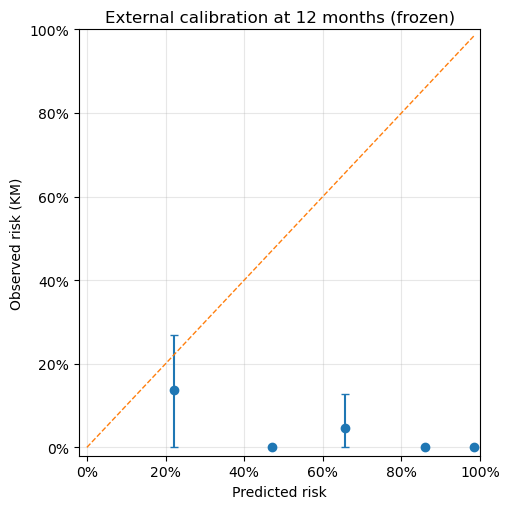

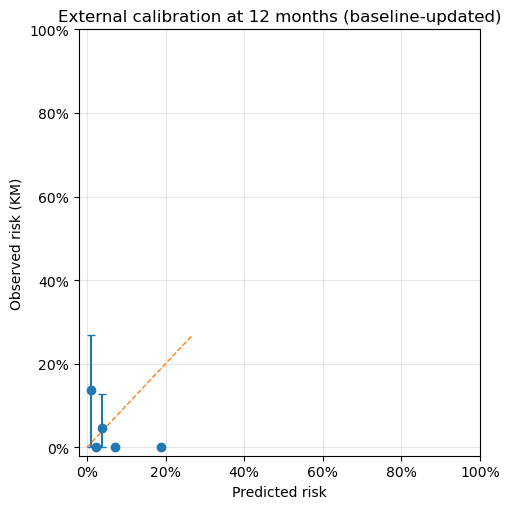

In [19]:
def plot_calibration_table_2(
    cal_df: pd.DataFrame,
    title: str,
    percent: bool = True,
    show_45deg: bool = True,
    capsize: int = 3,
    xlim: tuple[float,float] | None = None,
    ylim: tuple[float,float] | None = None,
):
    """
    Plots grouped calibration:
      x = mean predicted risk in bin
      y = observed KM risk in bin with Greenwood CI (obs_lo, obs_hi)
    """
    df = tidy_calibration_df(cal_df)

    x  = df["mean_pred"].to_numpy(float)
    y  = df["obs_km"].to_numpy(float)
    lo = df["obs_lo"].to_numpy(float)
    hi = df["obs_hi"].to_numpy(float)

    # yerr for matplotlib: [[lower errs], [upper errs]]
    yerr_low = np.maximum(y - lo, 0.0)
    yerr_high = np.maximum(hi - y, 0.0)

    fig, ax = plt.subplots(figsize=(5.2, 5.2))
    ax.errorbar(x, y, yerr=np.vstack([yerr_low, yerr_high]), fmt="o", capsize=capsize)

    # default limits based on data
    maxv = float(np.nanmax(np.r_[x, y, hi])) if len(x) else 1.0
    maxv = max(maxv, 1e-6)

    if show_45deg:
        ax.plot([0, maxv], [0, maxv], "--", linewidth=1)

    ax.set_xlabel("Predicted risk")
    ax.set_ylabel("Observed risk (KM)")
    ax.set_title(title)

    if xlim is None:
        ax.set_xlim(0, maxv)
    else:
        ax.set_xlim(*xlim)

    if ylim is None:
        ax.set_ylim(0, maxv)
    else:
        ax.set_ylim(*ylim)

    if percent:
        fmt = FuncFormatter(lambda v, p: f"{100*v:.0f}%")
        ax.xaxis.set_major_formatter(fmt)
        ax.yaxis.set_major_formatter(fmt)

    ax.grid(alpha=0.3)
    plt.tight_layout()
    return fig, ax

# Calibration plots
t0 = res_ext["t0_months"]

cal_frozen_2 = res_ext["calibration_table_frozen"]
cal_updated_2 = res_ext["calibration_table_updated"]

# Frozen
fig1, ax1 = plot_calibration_table_2(cal_frozen_2, xlim=(-0.02, 1), ylim=(-0.02, 1),
                                      title=f"External calibration at {t0} months (frozen)", percent=True)

# Updated
fig2, ax2 = plot_calibration_table_2(cal_updated_2, xlim=(-0.02, 1), ylim=(-0.02, 1),
                                      title=f"External calibration at {t0} months (baseline-updated)", percent=True)

# Optional: If you want "clean" calibration tables with CI in a separate column for slides:
cal_frozen_tidy = tidy_calibration_table(cal_frozen_2)
cal_updated_tidy = tidy_calibration_table(cal_updated_2)

In [20]:
# display(cal_frozen_tidy)
# display(cal_updated_tidy)

So while you can generate predictions at 50 months, you cannot validate them.

Prediction may be possible. Validation is not.


If you pretend the second trial has 50 months of follow-up:

You create informative censoring

You inflate uncertainty

You risk misleading conclusions about long-term survival

You can say:

“The model was trained on a 50-month trial and externally validated on an independent 22-month trial. Model performance was assessed at clinically relevant time points up to 22 months.”

<!-- ## Prognostic Scores for Baseline Model (fit) -->

In [21]:
# train_df = prognostic_score(train_df, fp_model, groups=3)
# train_df.head(3)

In [22]:
# train_df['risk_group'] = pd.qcut(train_df['prognostic_score'], 3, labels=['Low','Medium','High'])

# train_df.head(6)
# train_df.risk_group.value_counts().to_dict()

In [23]:
# for group in ['Low','Medium','High']:
#     subset = train_df[train_df['risk_group']==group]
#     kmf = KaplanMeierFitter()
#     kmf.fit(subset['Disease_Duration'], subset['Event'], label=group)
#     kmf.plot_survival_function()
# plt.title("K–M - Prognostic Score")
# plt.xlabel("Time")
# plt.ylabel("Survival Probability")
# plt.legend(title="Risk Group")
# plt.grid(True)
# plt.show()

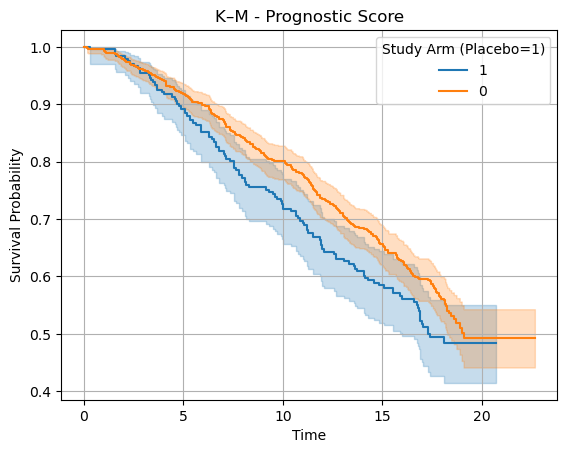

In [24]:
for group in [1,0]:
    subset = ril_3010[ril_3010['Study_Arm_Placebo']==group]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=group)
    kmf.plot_survival_function()
plt.title("K–M - Prognostic Score")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend(title="Study Arm (Placebo=1)")
plt.grid(True)
# plt.ylim(0,1.1)
plt.show()

In [25]:
# predict survival curves over a time grid (with optional shrinkage and optional coef override)
# 1) R helper: predict S(t) for many times (and allow coefficient override)
_r_predict_surv_curve = R("""
function(model, newdata, times, coef_override=NULL){
  m2 <- model

  if(!is.null(coef_override)){
    try({ coef(m2) <- coef_override }, silent=TRUE)
    if(is.null(coef(m2)) || any(is.na(coef(m2)))){
      m2$coefficients <- coef_override
    }
  }

  out <- sapply(times, function(tt){
    tmp <- newdata
    # FORCE the prediction time to be the same variable used in Surv(...)
    tmp$Disease_Duration <- rep(as.numeric(tt), nrow(tmp))
    as.numeric(predict(m2, newdata=tmp, type="surv", timevar="Disease_Duration"))
  })

  out
}
""")



# Python wrapper: average virtual placebo curve for a treated dataset
# This uses your model trained on placebo, and predicts “what would happen on placebo” for treated patients.
def virtual_placebo_survival_curve(
    model_placebo,
    treated_df: pd.DataFrame,
    vars_final: list[str],
    time_grid: np.ndarray,
    shrinkage: float = 1.0,
    coef_boot: np.ndarray | None = None,
):
    """
    Returns:
      avg_S: (T,) average survival over treated patients if on placebo
      S_mat: (n, T) individual survival curves
    Options:
      - shrinkage: multiply covariate coefficients by shrinkage (leave baseline terms alone)
      - coef_boot: if provided, use this coefficient vector (e.g., from bootstrap replicate)
    """
    # Prepare R df with the columns needed by the model
    needed = ["Disease_Duration"] + list(vars_final)
    tmp = treated_df.copy()
    # ensure required columns exist
    for c in needed:
        if c not in tmp.columns:
            raise ValueError(f"treated_df missing column: {c}")
    r_treated = to_r_df(tmp[needed])

    # Get base coefficients from model
    b = np.asarray(list(ro.r["coef"](model_placebo)), dtype=float)
    names = list(map(str, ro.r["names"](ro.r["coef"](model_placebo))))
    idx = {n: i for i, n in enumerate(names)}

    # choose coefficients to use
    if coef_boot is not None:
        b_use = np.asarray(coef_boot, dtype=float).copy()
        if len(b_use) != len(b):
            raise ValueError("coef_boot must match length of coef(model_placebo)")
    else:
        b_use = b.copy()

    # Apply shrinkage ONLY to covariate terms that match vars_final
    for v in vars_final:
        if v in idx:
            b_use[idx[v]] = b_use[idx[v]] * float(shrinkage)

    # Predict survival curves: returns n x T matrix in R, convert to numpy
    S_mat = np.asarray(_r_predict_surv_curve(
        model_placebo,
        r_treated,
        ro.FloatVector(np.asarray(time_grid, float).tolist()),
        ro.FloatVector(b_use.tolist())
    ), dtype=float)

    # R returns matrix with dim T x n or n x T depending on sapply; enforce shape
    # We expect S_mat shape: (len(time_grid), n) sometimes.
    if S_mat.shape[0] == len(time_grid) and S_mat.shape[1] == len(treated_df):
        S_mat = S_mat.T  # -> n x T

    avg_S = np.mean(S_mat, axis=0)  # (T,)
    return avg_S, S_mat


# Kaplan–Meier curves in Python (for your three plots)
from lifelines import KaplanMeierFitter

def km_curve(df: pd.DataFrame, label: str):
    km = KaplanMeierFitter()
    km.fit(durations=df["Disease_Duration"], event_observed=(df["Event"] == 1), label=label)
    return km


# The three plots from the pipeline (drop-in)
# 1) Plot 1: Observed treated vs historical placebo (both KM)
import matplotlib.pyplot as plt

def plot_km_treated_vs_hist_placebo(treated_df, hist_placebo_df, x_max=24):
    km_t = km_curve(treated_df, "Observed treated (KM)")
    km_p = km_curve(hist_placebo_df, "Historical placebo (KM)")

    ax = km_t.plot_survival_function(ci_show=True)
    km_p.plot_survival_function(ci_show=True, ax=ax)

    plt.xlim(0, x_max)
    plt.xlabel("Time (months)")
    plt.ylabel("Survival probability")
    plt.title("Observed treated vs historical placebo")
    plt.show()


# 2) Plot 2: Virtual placebo vs observed treated
def plot_virtual_placebo_vs_treated(
    model_placebo,
    treated_df,
    vars_final,
    time_grid,
    shrinkage=1.0,
    x_max=24
):
    avg_S, _ = virtual_placebo_survival_curve(
        model_placebo=model_placebo,
        treated_df=treated_df,
        vars_final=vars_final,
        time_grid=time_grid,
        shrinkage=shrinkage,
        coef_boot=None
    )

    km_t = km_curve(treated_df, "Observed treated (KM)")

    plt.figure()
    plt.plot(time_grid, avg_S, label="Virtual placebo (avg predicted)")
    ax = km_t.plot_survival_function(ci_show=True)
    plt.xlim(0, x_max)
    plt.xlabel("Time (months)")
    plt.ylabel("Survival probability")
    plt.title("Virtual placebo vs observed treated")
    plt.legend()
    plt.show()



# 3) Plot 3: Hybrid design (small real placebo + virtual placebo + treated)
def plot_hybrid(
    model_placebo,
    treated_df,
    placebo_small_df,
    vars_final,
    time_grid,
    shrinkage=1.0,
    x_max=24
):
    avg_S, _ = virtual_placebo_survival_curve(
        model_placebo=model_placebo,
        treated_df=treated_df,
        vars_final=vars_final,
        time_grid=time_grid,
        shrinkage=shrinkage,
        coef_boot=None
    )

    km_t = km_curve(treated_df, "Observed treated (KM)")
    km_p = km_curve(placebo_small_df, "Observed placebo (small KM)")

    ax = km_p.plot_survival_function(ci_show=True)
    km_t.plot_survival_function(ci_show=True, ax=ax)
    plt.plot(time_grid, avg_S, label="Virtual placebo (avg predicted)")

    plt.xlim(0, x_max)
    plt.xlabel("timeline")
    plt.ylabel("Survival probability")
    plt.title("Hybrid design: small real placebo + virtual placebo + treated")
    plt.legend()
    plt.show()

In [26]:
dat_trt = ril_3010_trt
time_grid = np.linspace(0.5, 24, 120)

avg_S, S_mat = virtual_placebo_survival_curve(
    model_placebo=model_final,     # your placebo-trained stpm2
    treated_df=dat_trt,          # treated cohort
    vars_final=vars_final,
    time_grid=time_grid,
    shrinkage=shrinkage,
    coef_boot=None
)


In [27]:
print("time_grid[:5]:", time_grid[:5])
print("avg_S shape:", avg_S.shape)
print("avg_S[:5]:", avg_S[:5])
print("avg_S[-5:]:", avg_S[-5:])

time_grid[:5]: [0.5        0.69747899 0.89495798 1.09243697 1.28991597]
avg_S shape: (120,)
avg_S[:5]: [0.99718036 0.99509733 0.9925886  0.98969614 0.98645298]
avg_S[-5:]: [0.3818295  0.37843342 0.37507359 0.3717496  0.36846101]


In [28]:
print("S_mat shape:", S_mat.shape)
print("First patient first 5:", S_mat[0, :5])
print("First patient last 5:", S_mat[0, -5:])


S_mat shape: (715, 120)
First patient first 5: [0.99570976 0.99253483 0.98870487 0.98428074 0.9793096 ]
First patient last 5: [0.07430321 0.071603   0.06898647 0.06645168 0.06399668]


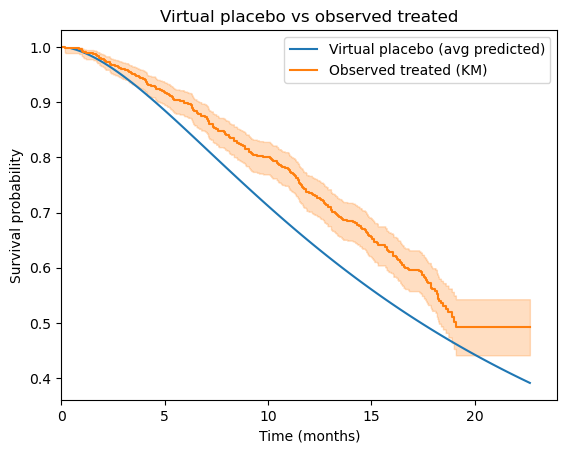

In [29]:
dat_trt = ril_3010_trt
time_max = dat_trt["Disease_Duration"].max()

time_grid = np.linspace(0.5, time_max, 100)  # avoid 0 exactly sometimes
plot_virtual_placebo_vs_treated(
    model_placebo=model_final,          # placebo model
    treated_df=dat_trt,              # <-- your treated cohort
    vars_final=vars_final,
    time_grid=time_grid,
    shrinkage=shrinkage
)


In [30]:
def virtual_placebo_band_from_bootstrap(
    model_placebo,
    treated_df,
    vars_final,
    time_grid,
    boot_coefs: list[np.ndarray],
    shrinkage=1.0,
    q=(2.5, 97.5)
):
    curves = []
    for b in boot_coefs:
        avg_S, _ = virtual_placebo_survival_curve(
            model_placebo=model_placebo,
            treated_df=treated_df,
            vars_final=vars_final,
            time_grid=time_grid,
            shrinkage=shrinkage,
            coef_boot=b
        )
        curves.append(avg_S)

    C = np.vstack(curves)  # B x T
    lo = np.percentile(C, q[0], axis=0)
    hi = np.percentile(C, q[1], axis=0)
    mid = np.median(C, axis=0)
    return mid, lo, hi



def plot_virtual_placebo_with_band(
    model_placebo, treated_df, vars_final, time_grid,
    boot_coefs, shrinkage=1.0, x_max=24
):
    mid, lo, hi = virtual_placebo_band_from_bootstrap(
        model_placebo, treated_df, vars_final, time_grid,
        boot_coefs=boot_coefs,
        shrinkage=shrinkage
    )

    km_t = km_curve(treated_df, "Observed treated (KM)")
    plt.figure()
    plt.plot(time_grid, mid, label="Virtual placebo (median)")
    plt.fill_between(time_grid, lo, hi, alpha=0.2, label="Virtual placebo 95% band")
    ax = km_t.plot_survival_function(ci_show=True)
    plt.xlim(0, x_max)
    plt.xlabel("Time (months)")
    plt.ylabel("Survival probability")
    plt.title("Virtual placebo (bootstrap band) vs observed treated")
    plt.legend()
    plt.show()


avg_S_updated = np.power(avg_S, res_ext["baseline_factor"])


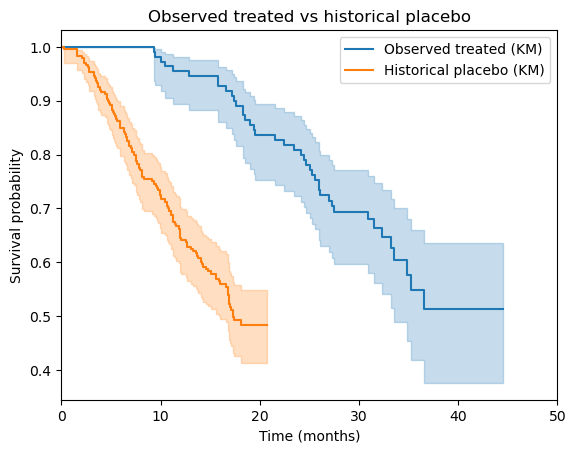

In [31]:
hist_placebo_df = prep_df(ril_3010_pla.copy(), covariates)
treated_df      = prep_df(miro0_trt.copy(), covariates)     # <-- YOU set this
placebo_small_df = prep_df(miro0_pla.copy(), covariates)  # optional

time_grid = np.linspace(0.5, 50, 100)

plot_km_treated_vs_hist_placebo(treated_df, hist_placebo_df, x_max=50)


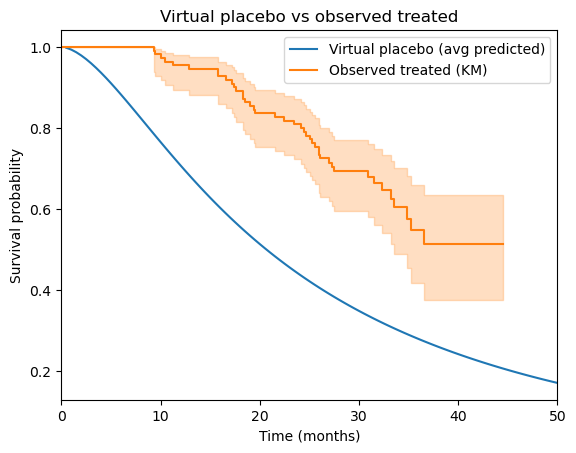

In [32]:

plot_virtual_placebo_vs_treated(
    model_placebo=model_final,
    treated_df=treated_df,
    vars_final=vars_final,
    time_grid=time_grid,
    shrinkage=shrinkage,
    x_max=50
)


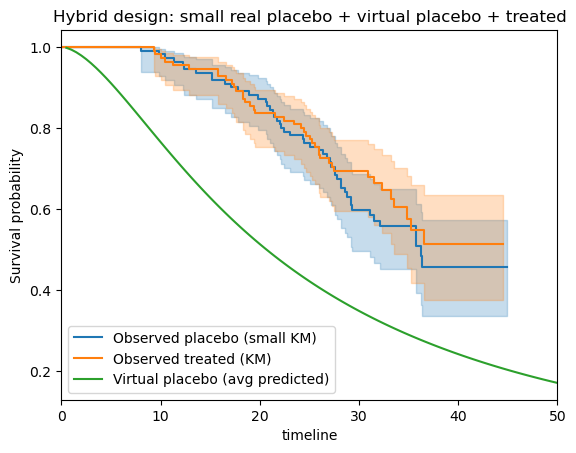

In [33]:

plot_hybrid(
    model_placebo=model_final,
    treated_df=treated_df,
    placebo_small_df=placebo_small_df,
    vars_final=vars_final,
    time_grid=time_grid,
    shrinkage=shrinkage,
    x_max=50
)


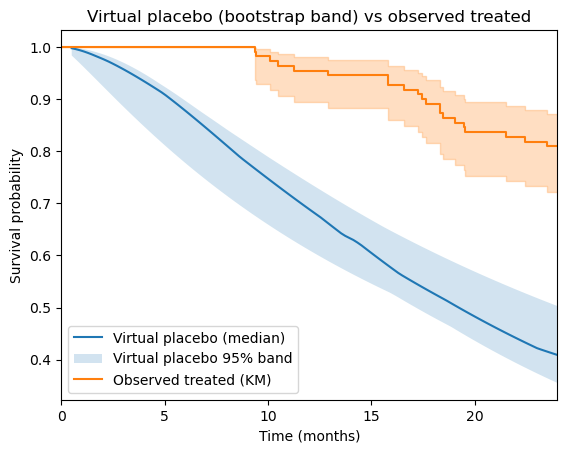

In [34]:
time_grid = np.linspace(0.5, 24, 120)

plot_virtual_placebo_with_band(
    model_placebo=model_final,
    treated_df=treated_df,
    vars_final=vars_final,
    time_grid=time_grid,
    boot_coefs=boot_coefs,
    shrinkage=shrinkage
)


## ***Simulate Virtual Placebo***

In [35]:
coef = coef_summary_tbl_2
coef

,Variable,log(HR) apparent,95% CI log(HR) apparent,HR apparent,95% CI HR apparent,log(HR) shrunk,95% CI log(HR) shrunk,HR shrunk,95% CI HR shrunk
0,Age,0.770,"[0.550, 0.990]",2.159,"[1.733, 2.690]",0.764,"[0.546, 0.982]",2.147,"[1.726, 2.670]"
1,Diagnostic_Delay,0.098,"[-0.092, 0.288]",1.103,"[0.912, 1.333]",0.097,"[-0.091, 0.286]",1.102,"[0.913, 1.331]"
2,Vital_capacity,-0.684,"[-0.888, -0.479]",0.505,"[0.411, 0.619]",-0.678,"[-0.881, -0.476]",0.507,"[0.414, 0.622]"
3,Onset_Limb,1.369,"[-0.605, 3.343]",3.931,"[0.546, 28.305]",1.358,"[-0.600, 3.317]",3.890,"[0.549, 27.582]"
4,Sex_Male,-0.297,"[-0.682, 0.088]",0.743,"[0.505, 1.092]",-0.295,"[-0.677, 0.088]",0.745,"[0.508, 1.092]"


In [36]:
float(coef[coef['Variable'] == 'Age']['log(HR) apparent'].values[0])

0.77

In [37]:
dat_set.info() # ril_3010_pla

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 1 to 956
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         240 non-null    int64  
 1   Event              240 non-null    int64  
 2   Disease_Duration   240 non-null    float64
 3   Study_Arm_Placebo  240 non-null    int64  
 4   Age                240 non-null    float64
 5   TRICALS            240 non-null    float64
 6   Diagnostic_Delay   240 non-null    float64
 7   Vital_capacity     240 non-null    float64
 8   Onset_Limb         240 non-null    int64  
 9   Sex_Male           240 non-null    int64  
 10  Sex_onset          240 non-null    int64  
 11  Age_Sex            240 non-null    float64
 12  Age_onset          240 non-null    float64
 13  Age_TRICALS        240 non-null    float64
 14  Age_VC             240 non-null    float64
 15  Sex_VC             240 non-null    float64
 16  Onset_VC           240 non-null

In [38]:
cols = ['subject_id']

for col in (dat_set.select_dtypes(include=['object', 'category', 'int']).columns):
    if col not in cols:
        print(f"{dat_set[col].value_counts() / dat_set[col].value_counts().sum()}\n")

Event
0    0.508333
1    0.491667
Name: count, dtype: float64

Study_Arm_Placebo
1    1.0
Name: count, dtype: float64

Onset_Limb
1    0.9625
0    0.0375
Name: count, dtype: float64

Sex_Male
1    0.625
0    0.375
Name: count, dtype: float64

Sex_onset
1    0.6
0    0.4
Name: count, dtype: float64



In [39]:
ons = dat_set['Onset_Limb'].value_counts() / dat_set['Onset_Limb'].value_counts().sum()
sex = dat_set['Sex_Male'].value_counts() / dat_set['Sex_Male'].value_counts().sum()
# pla = dat_set['Study_Arm_Placebo'].value_counts() / dat_set['Study_Arm_Placebo'].value_counts().sum()
# exp = dat_set['Expt_mirocals'].value_counts() / dat_set['Expt_mirocals'].value_counts().sum()
# eur = dat_set['European_Yes'].value_counts() / dat_set['European_Yes'].value_counts().sum()


In [40]:
ons, sex

(Onset_Limb
 1    0.9625
 0    0.0375
 Name: count, dtype: float64,
 Sex_Male
 1    0.625
 0    0.375
 Name: count, dtype: float64)

In [41]:
dat_set.head(3)

,subject_id,Event,Disease_Duration,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS,Age_VC,Sex_VC,Onset_VC,Age_sq
1,11002,0,19.152431,1,-1.337433,-1.652662,-0.53026,1.841255,1,1,1,-1.337433,-1.337433,2.210326,-2.462556,1.841255,1.841255,1.788728
5,11006,1,15.538765,1,1.031446,0.326797,-0.53026,-0.206105,1,1,1,1.031446,1.031446,0.337074,-0.212586,-0.206105,-0.206105,1.063881
8,11009,1,5.880420,1,1.669221,1.091771,-0.53026,-0.342044,1,0,0,0.000000,1.669221,1.822408,-0.570947,-0.000000,-0.342044,2.786299


In [42]:
dat_set.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb',
       'Sex_Male', 'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS',
       'Age_VC', 'Sex_VC', 'Onset_VC', 'Age_sq'],
      dtype='object')

In [43]:
coef['Variable'].tolist()

['Age', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb', 'Sex_Male']

In [44]:
corr = dat_set[coef['Variable'].tolist()].corr()
corr

,Age,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male
Age,1.000000,-0.042376,0.030842,0.165263,-0.230413
Diagnostic_Delay,-0.042376,1.000000,0.130383,0.022590,-0.071538
Vital_capacity,0.030842,0.130383,1.000000,-0.059355,-0.154640
Onset_Limb,0.165263,0.022590,-0.059355,1.000000,-0.016988
Sex_Male,-0.230413,-0.071538,-0.154640,-0.016988,1.000000


In [45]:
df = coef.copy()
df

,Variable,log(HR) apparent,95% CI log(HR) apparent,HR apparent,95% CI HR apparent,log(HR) shrunk,95% CI log(HR) shrunk,HR shrunk,95% CI HR shrunk
0,Age,0.770,"[0.550, 0.990]",2.159,"[1.733, 2.690]",0.764,"[0.546, 0.982]",2.147,"[1.726, 2.670]"
1,Diagnostic_Delay,0.098,"[-0.092, 0.288]",1.103,"[0.912, 1.333]",0.097,"[-0.091, 0.286]",1.102,"[0.913, 1.331]"
2,Vital_capacity,-0.684,"[-0.888, -0.479]",0.505,"[0.411, 0.619]",-0.678,"[-0.881, -0.476]",0.507,"[0.414, 0.622]"
3,Onset_Limb,1.369,"[-0.605, 3.343]",3.931,"[0.546, 28.305]",1.358,"[-0.600, 3.317]",3.890,"[0.549, 27.582]"
4,Sex_Male,-0.297,"[-0.682, 0.088]",0.743,"[0.505, 1.092]",-0.295,"[-0.677, 0.088]",0.745,"[0.508, 1.092]"


In [46]:
def corr_matrix_from_var_specs(df: pd.DataFrame, var_specs: list[dict]) -> np.ndarray:
    """
    Build correlation matrix in the exact same order as var_specs.
    Works when df contains these columns.
    """
    var_order = [v["name"] for v in var_specs]
    missing = [v for v in var_order if v not in df.columns]
    if missing:
        raise ValueError(f"df is missing variables required for correlation: {missing}")

    corr = df[var_order].corr().to_numpy()
    return corr


In [47]:
var_specs_real = [
    # continuous
    {'name':'Age','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "Age", "log(HR) shrunk"].values[0]},
    # {'name':'TRICALS','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "TRICALS", "log(HR) shrunk"].values[0]},
    {'name':'Diagnostic_Delay','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
                                                           'coef':df.loc[df["Variable"] == "Diagnostic_Delay", "log(HR) shrunk"].values[0]},
    {'name':'Vital_capacity','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
                                                           'coef':df.loc[df["Variable"] == "Vital_capacity", "log(HR) shrunk"].values[0]},

    # binary
    {'name':'Sex_Male','type':'binary','prob':sex[1],'coef':df.loc[df["Variable"] == "Sex_Male", "log(HR) shrunk"].values[0]},
    {'name':'Onset_Limb','type':'binary','prob':ons[1],'coef':df.loc[df["Variable"] == "Onset_Limb", "log(HR) shrunk"].values[0]},
    # {'name':'Expt_mirocals','type':'binary','prob':exp[1],'coef':df.loc[df["Variable"] == "Expt_mirocals", "log(HR) shrunk"].values[0]},
    # {'name':'Study_Arm_Placebo','type':'binary','prob':pla[1],'coef':df.loc[df["Variable"] == "Study_Arm_Placebo", "log(HR) shrunk"].values[0]},

    # # categorical
    # {'name':'Onset_site','type':'categorical',
    #  'levels':['bulbar','limb','other'],'probs':[0.218484,0.746833,0.034683],
    #  'coef':{'limb':1.151159,'other':2.508786},'ref':'bulbar'}
]

corr = corr_matrix_from_var_specs(dat_set, var_specs_real)
corr

array([[ 1.        , -0.04237609,  0.03084218, -0.2304128 ,  0.16526275],
       [-0.04237609,  1.        ,  0.13038293, -0.07153827,  0.02258979],
       [ 0.03084218,  0.13038293,  1.        , -0.15463993, -0.05935531],
       [-0.2304128 , -0.07153827, -0.15463993,  1.        , -0.01698824],
       [ 0.16526275,  0.02258979, -0.05935531, -0.01698824,  1.        ]])

In [ ]:
# def sample_censoring_times_from_censored_only(
#     placebo_df: pd.DataFrame,
#     n: int,
#     time_col: str,
#     event_col: str,
#     rng: np.random.Generator,
# ) -> np.ndarray:
#     """
#     Empirical resampling of censoring times using only censored participants.
#     Assumes event_col == 1 indicates event, 0 indicates censored.
#     """
#     cens_times = placebo_df.loc[placebo_df[event_col] == 0, time_col].to_numpy(dtype=float)

#     if len(cens_times) == 0:
#         raise ValueError("No censored observations found; cannot resample censoring times.")

#     return rng.choice(cens_times, size=n, replace=True)


In [48]:
dat_set.Event.value_counts() / dat_set.Event.value_counts().sum()

Event
0    0.508333
1    0.491667
Name: count, dtype: float64

In [49]:
# H0_df = estimate_baseline_cumhaz(dat_set, time_col='Disease_Duration', event_col='Event')

H0_df, cph = estimate_baseline_cumhaz_breslow(placebo_df = dat_set,
                                     time_col = "Disease_Duration",
                                     event_col = "Event",
                                     covariate_cols= coef['Variable'].tolist())
# H0_df

In [50]:
len(var_specs_real)

5

In [51]:
type(H0_df)
H0_df.head()

,time,cumhaz
0,0.295664,0.002522
1,1.576873,0.007654
2,1.609724,0.010259
3,2.069645,0.012897
4,2.233903,0.015553


In [52]:
t_admin = dat_set["Disease_Duration"].max()
censored = dat_set[dat_set["Event"] == 0]
tol = 0.01 * t_admin  # 1% of study duration
admin_frac_hat = np.mean(
    censored["Disease_Duration"] >= (t_admin - tol)
)
admin_frac_hat

np.float64(0.00819672131147541)

In [53]:
sim_df = simulate_cox_dataset_with_correlation(
    n=len(dat_set),
    baseline="empirical",
    H0_df=H0_df,                         # IMPORTANT: should be Cox baseline cumhaz
    censoring="mixture_admin_dropout",   # or "administrative", mixture_admin_dropout
    placebo_df_for_censor=dat_set,
    time_col_censor="Disease_Duration",
    event_col_censor="Event",
    seed=420,
    var_specs=var_specs_real,
    corr=corr,
    admin_frac=admin_frac_hat
)


In [54]:
sim_df.head(3)

,time,event,true_survival_time,linear_predictor,Age,Diagnostic_Delay,Vital_capacity,Sex_Male,Onset_Limb
0,8.120364,1,8.120364,0.257878,-1.146794,-0.785881,-0.217196,1,1
1,1.602172,1,1.602172,1.772456,-0.497373,1.342746,-0.979650,0,1
2,1.015580,1,1.015580,0.689014,-1.180274,1.762483,-0.526228,1,1


In [55]:
sim_df.event.value_counts() #/ sim_df.event.value_counts().sum()

event
1    176
0     64
Name: count, dtype: int64

In [56]:
dat_set.head(3)

,subject_id,Event,Disease_Duration,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS,Age_VC,Sex_VC,Onset_VC,Age_sq
1,11002,0,19.152431,1,-1.337433,-1.652662,-0.53026,1.841255,1,1,1,-1.337433,-1.337433,2.210326,-2.462556,1.841255,1.841255,1.788728
5,11006,1,15.538765,1,1.031446,0.326797,-0.53026,-0.206105,1,1,1,1.031446,1.031446,0.337074,-0.212586,-0.206105,-0.206105,1.063881
8,11009,1,5.880420,1,1.669221,1.091771,-0.53026,-0.342044,1,0,0,0.000000,1.669221,1.822408,-0.570947,-0.000000,-0.342044,2.786299


In [57]:
dat_set.Event.value_counts() / dat_set.Event.value_counts().sum()

Event
0    0.508333
1    0.491667
Name: count, dtype: float64

In [58]:
# ons = dat_set['Onset_Limb'].value_counts() / dat_set['Onset_Limb'].value_counts().sum()
# sex = dat_set['Sex_Male'].value_counts() / dat_set['Sex_Male'].value_counts().sum()
# # sex_ons = dat_set['Sex_onset'].value_counts() / dat_set['Sex_onset'].value_counts().sum()
# print(ons, sex)#, sex_ons)

# print("\n---- Simulated data ----")
# ons1 = sim_df['Onset_Limb'].value_counts() / sim_df['Onset_Limb'].value_counts().sum()
# sex1 = sim_df['Sex_Male'].value_counts() / sim_df['Sex_Male'].value_counts().sum()
# # sex_ons1 = sim_df['Sex_onset'].value_counts() / sim_df['Sex_onset'].value_counts().sum()

# print(ons1, sex1) #, sex_ons1)

### **Compare Original Active to Original Placebo and Simulated Placebo**

In [59]:
# print(ril_3010.shape, ril_3010_pla.shape, sim_df.shape)

In [60]:
sim_df.columns

Index(['time', 'event', 'true_survival_time', 'linear_predictor', 'Age',
       'Diagnostic_Delay', 'Vital_capacity', 'Sex_Male', 'Onset_Limb'],
      dtype='object')

In [61]:
sim_df.head(3)

,time,event,true_survival_time,linear_predictor,Age,Diagnostic_Delay,Vital_capacity,Sex_Male,Onset_Limb
0,8.120364,1,8.120364,0.257878,-1.146794,-0.785881,-0.217196,1,1
1,1.602172,1,1.602172,1.772456,-0.497373,1.342746,-0.979650,0,1
2,1.015580,1,1.015580,0.689014,-1.180274,1.762483,-0.526228,1,1


In [ ]:
# sim_df.info()


In [62]:
tested_time = 'time'

sim_new = sim_df[[tested_time, 'event', 'Age', 'Diagnostic_Delay',
                      'Vital_capacity', 'Onset_Limb', 'Sex_Male']].copy()

sim_new = sim_new.rename(columns={tested_time :'Disease_Duration',
                                    'event':'Event'})   

sim_new['Study_Arm_Placebo'] = 2

sim_new.head(3)      

,Disease_Duration,Event,Age,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Study_Arm_Placebo
0,8.120364,1,-1.146794,-0.785881,-0.217196,1,1,2
1,1.602172,1,-0.497373,1.342746,-0.979650,1,0,2
2,1.015580,1,-1.180274,1.762483,-0.526228,1,1,2


In [63]:
ril_3010_new = ril_3010[['Disease_Duration', 'Event', 'Age', 'Diagnostic_Delay',
                      'Vital_capacity', 'Onset_Limb', 'Sex_Male', 'Study_Arm_Placebo']].copy()
    
print(ril_3010_new['Study_Arm_Placebo'].value_counts())
ril_3010_new.head(3)

Study_Arm_Placebo
0    715
1    242
Name: count, dtype: int64


,Disease_Duration,Event,Age,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Study_Arm_Placebo
0,7.161629,1,0.667003,0.607142,-0.680409,1,1,0
1,19.152431,0,-1.337433,-0.530260,1.841255,1,1,1
2,18.232589,1,0.484782,1.549016,-0.314536,1,1,0


In [64]:
ril_sim = pd.concat([ril_3010_new, sim_new], axis=0).reset_index(drop=True)
print(f"{ril_sim.shape}\n")

print(ril_sim['Study_Arm_Placebo'].value_counts())

(1197, 8)

Study_Arm_Placebo
0    715
1    242
2    240
Name: count, dtype: int64


In [ ]:
# ril_sim.info()

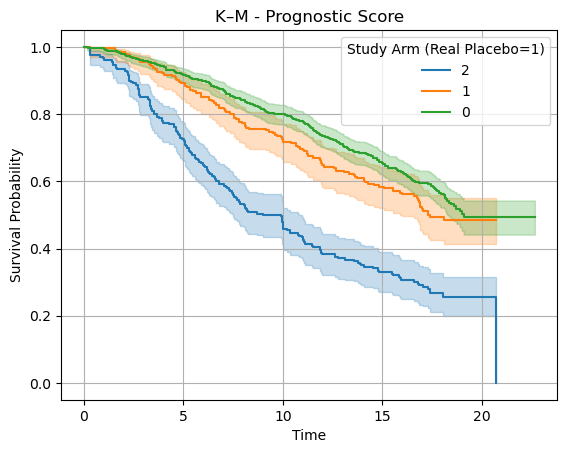

In [65]:
for group in [2, 1, 0]:
    subset = ril_sim[ril_sim['Study_Arm_Placebo']==group]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=group)
    kmf.plot_survival_function()
plt.title("K–M - Prognostic Score")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend(title="Study Arm (Real Placebo=1)")
plt.grid(True)
# plt.ylim(0,1.1)
plt.show()

In [66]:
def sample_censoring_times_from_censored_only(
    placebo_df: pd.DataFrame,
    n: int,
    time_col: str,
    event_col: str,
    rng: np.random.Generator,
) -> np.ndarray:
    """
    Empirical resampling of censoring times using only censored participants.
    Assumes event_col == 1 indicates event, 0 indicates censored.
    """
    cens_times = placebo_df.loc[placebo_df[event_col] == 0, time_col].to_numpy(dtype=float)

    if len(cens_times) == 0:
        raise ValueError("No censored observations found; cannot resample censoring times.")

    return rng.choice(cens_times, size=n, replace=True)


def sample_followup_times_empirical(
    placebo_df: pd.DataFrame,
    n: int,
    time_col: str,
    rng: np.random.Generator,
) -> np.ndarray:
    """
    Resample observed follow-up times (regardless of event status).
    """
    times = placebo_df[time_col].to_numpy(dtype=float)
    return rng.choice(times, size=n, replace=True)


In [67]:
def simulate_virtual_once(placebo_df, var_specs, seed):
    corr = corr_matrix_from_var_specs(placebo_df, var_specs)
    H0_df = estimate_baseline_cumhaz(placebo_df, time_col="Disease_Duration", event_col="Event")

    df_sim = simulate_cox_dataset_with_correlation(
        n=len(placebo_df),
        baseline="empirical",
        H0_df=H0_df,
        censoring="empirical_censored_only",        # or "empirical_followup"
        placebo_df_for_censor=placebo_df,           # <-- THIS FIXES YOUR ERROR
        time_col_censor="Disease_Duration",
        event_col_censor="Event",
        seed=seed,
        var_specs=var_specs,
        corr=corr
    )
    return df_sim


In [68]:
def plot_km_overlay_with_virtual_bands(placebo_df, var_specs, n_boot=300, seed=123):
    # Fit real placebo KM
    km_real = KaplanMeierFitter()
    km_real.fit(placebo_df["Disease_Duration"], event_observed=placebo_df["Event"], label="Real placebo")

    # Time grid for bands (use real event-time range)
    tmax = np.nanmax(placebo_df["Disease_Duration"].to_numpy(float))
    grid = np.linspace(0, tmax, 200)

    # Bootstrap virtual KMs
    rng = np.random.default_rng(seed)
    S_boot = []

    for b in range(n_boot):
        df_sim_b = simulate_virtual_once(placebo_df, var_specs, seed=int(rng.integers(0, 2**32 - 1)))
        km_v = KaplanMeierFitter()
        km_v.fit(df_sim_b["time"], event_observed=df_sim_b["event"])

        # Evaluate survival at grid points
        s = km_v.predict(grid).to_numpy()
        S_boot.append(s)

    S_boot = np.vstack(S_boot)
    lo = np.nanpercentile(S_boot, 2.5, axis=0)
    hi = np.nanpercentile(S_boot, 97.5, axis=0)
    med = np.nanpercentile(S_boot, 50, axis=0)

    # Plot
    fig, ax = plt.subplots(figsize=(7, 5))
    km_real.plot(ax=ax)

    ax.plot(grid, med, label="Virtual placebo (median)")
    ax.fill_between(grid, lo, hi, alpha=0.2, label="Virtual placebo (95% band)")

    ax.set_title("Kaplan–Meier: real placebo vs virtual placebo")
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival probability")
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    return fig, ax

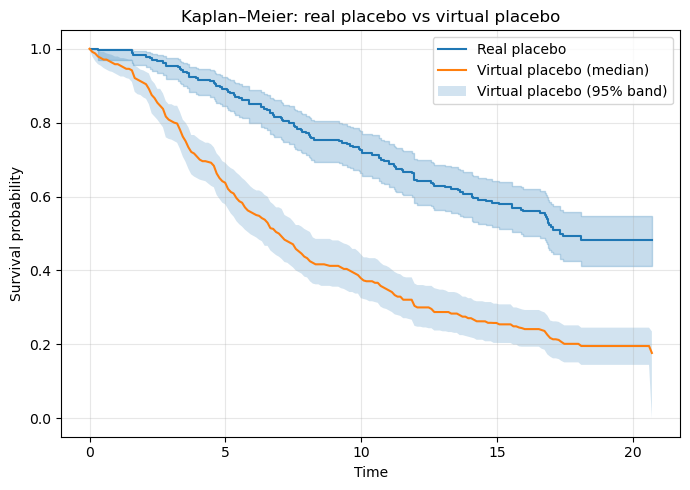

In [69]:
fig, ax = plot_km_overlay_with_virtual_bands(placebo_df=dat_set, var_specs = var_specs_real, n_boot=300, seed=2026)

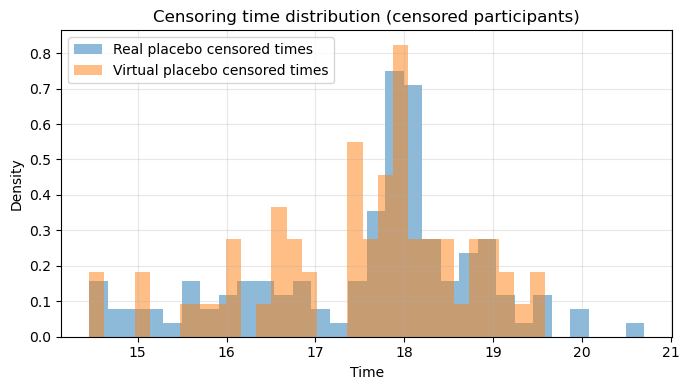

In [70]:
def plot_censoring_time_overlay(placebo_df, df_sim):
    # Censoring times among censored participants only
    real_cens = placebo_df.loc[placebo_df["Event"] == 0, "Disease_Duration"].to_numpy(float)
    sim_cens  = df_sim.loc[df_sim["event"] == 0, "time"].to_numpy(float)

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.hist(real_cens, bins=30, density=True, alpha=0.5, label="Real placebo censored times")
    ax.hist(sim_cens,  bins=30, density=True, alpha=0.5, label="Virtual placebo censored times")

    ax.set_title("Censoring time distribution (censored participants)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Density")
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    return fig, ax


fig, ax = plot_censoring_time_overlay(placebo_df = dat_set, df_sim = sim_df)


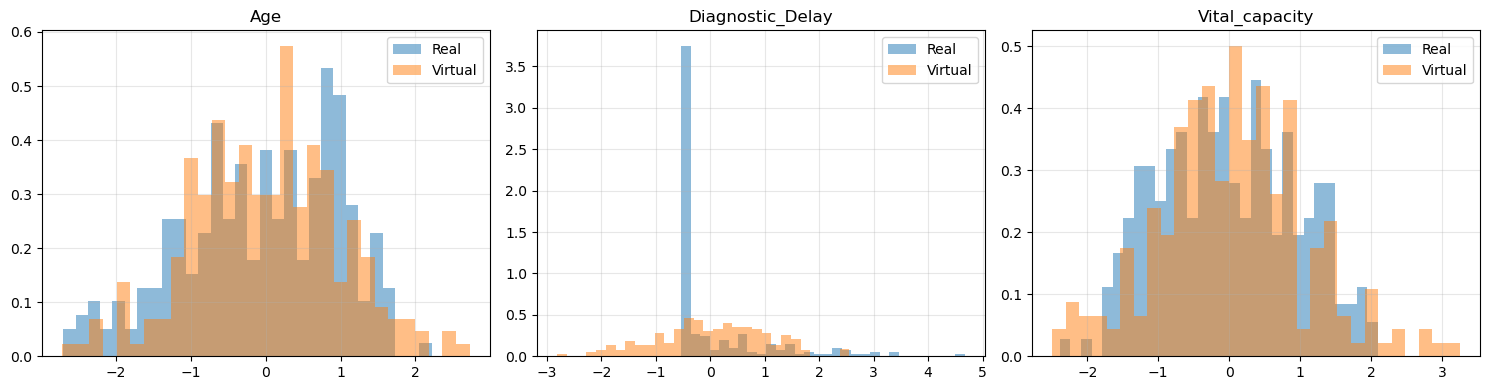

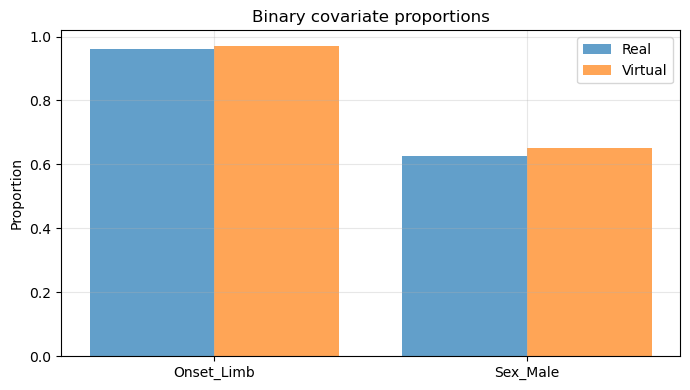

In [71]:
def standardized_mean_difference(x_real, x_sim, is_binary=False):
    x_real = np.asarray(x_real, float)
    x_sim  = np.asarray(x_sim, float)
    m1, m2 = np.nanmean(x_real), np.nanmean(x_sim)

    if is_binary:
        # Use pooled Bernoulli variance
        p = (m1 + m2) / 2.0
        denom = np.sqrt(max(p * (1 - p), 1e-12))
        return (m2 - m1) / denom

    s1, s2 = np.nanstd(x_real, ddof=1), np.nanstd(x_sim, ddof=1)
    denom = np.sqrt((s1**2 + s2**2) / 2.0 + 1e-12)
    return (m2 - m1) / denom


def plot_covariate_overlays_and_smd(placebo_df, df_sim):
    cont_vars = ["Age", "Diagnostic_Delay", "Vital_capacity"]
    bin_vars  = ["Onset_Limb", "Sex_Male"]

    # --- plot continuous overlays ---
    nrows = 1
    ncols = len(cont_vars)
    fig1, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4), squeeze=False)
    axes = axes.ravel()

    for i, v in enumerate(cont_vars):
        axes[i].hist(placebo_df[v].to_numpy(float), bins=30, density=True, alpha=0.5, label="Real")
        axes[i].hist(df_sim[v].to_numpy(float), bins=30, density=True, alpha=0.5, label="Virtual")
        axes[i].set_title(v)
        axes[i].grid(alpha=0.3)
        axes[i].legend()

    plt.tight_layout()

    # --- plot binary overlays ---
    fig2, ax2 = plt.subplots(figsize=(7, 4))
    x = np.arange(len(bin_vars))
    real_means = [float(placebo_df[v].mean()) for v in bin_vars]
    sim_means  = [float(df_sim[v].mean()) for v in bin_vars]

    ax2.bar(x - 0.2, real_means, width=0.4, alpha=0.7, label="Real")
    ax2.bar(x + 0.2, sim_means,  width=0.4, alpha=0.7, label="Virtual")
    ax2.set_xticks(x)
    ax2.set_xticklabels(bin_vars)
    ax2.set_ylabel("Proportion")
    ax2.set_title("Binary covariate proportions")
    ax2.grid(alpha=0.3)
    ax2.legend()
    plt.tight_layout()

    # --- standardized mean differences table ---
    rows = []
    for v in cont_vars:
        smd = standardized_mean_difference(placebo_df[v], df_sim[v], is_binary=False)
        rows.append((v, float(smd)))
    for v in bin_vars:
        smd = standardized_mean_difference(placebo_df[v], df_sim[v], is_binary=True)
        rows.append((v, float(smd)))

    smd_df = pd.DataFrame(rows, columns=["Covariate", "Standardized mean difference"])

    return (fig1, fig2, smd_df)


fig_cont, fig_bin, smd_df = plot_covariate_overlays_and_smd(placebo_df=dat_set, df_sim=sim_df)
# print(smd_df)


In [72]:
def simulate_virtual_once_admin_censor(placebo_df, var_specs, seed):
    corr = corr_matrix_from_var_specs(placebo_df, var_specs)
    H0_df = estimate_baseline_cumhaz(placebo_df, time_col="Disease_Duration", event_col="Event")

    df_sim = simulate_cox_dataset_with_correlation(
        n=len(placebo_df),
        baseline="empirical",
        H0_df=H0_df,
        censoring="empirical_censored_only",
        placebo_df_for_censor=placebo_df,
        time_col_censor="Disease_Duration",
        event_col_censor="Event",
        seed=seed,
        var_specs=var_specs,
        corr=corr
    )

    # overwrite with administrative censoring
    t_admin = float(placebo_df["Disease_Duration"].max())
    T = df_sim["true_survival_time"].to_numpy(float)
    df_sim["time"] = np.minimum(T, t_admin)
    df_sim["event"] = (T <= t_admin).astype(int)

    return df_sim


In [73]:
def plot_km_overlay_with_virtual_bands_admin(placebo_df, var_specs, n_boot=300, seed=123):
    # Fit real placebo KM
    km_real = KaplanMeierFitter()
    km_real.fit(placebo_df["Disease_Duration"], event_observed=placebo_df["Event"], label="Real placebo")

    # Time grid for bands (use real event-time range)
    tmax = np.nanmax(placebo_df["Disease_Duration"].to_numpy(float))
    grid = np.linspace(0, tmax, 200)

    # Bootstrap virtual KMs
    rng = np.random.default_rng(seed)
    S_boot = []

    for b in range(n_boot):
        df_sim_b = simulate_virtual_once_admin_censor(placebo_df, var_specs, seed=int(rng.integers(0, 2**32 - 1)))
        km_v = KaplanMeierFitter()
        km_v.fit(df_sim_b["time"], event_observed=df_sim_b["event"])

        # Evaluate survival at grid points
        s = km_v.predict(grid).to_numpy()
        S_boot.append(s)

    S_boot = np.vstack(S_boot)
    lo = np.nanpercentile(S_boot, 2.5, axis=0)
    hi = np.nanpercentile(S_boot, 97.5, axis=0)
    med = np.nanpercentile(S_boot, 50, axis=0)

    # Plot
    fig, ax = plt.subplots(figsize=(7, 5))
    km_real.plot(ax=ax)

    ax.plot(grid, med, label="Virtual placebo (median)")
    ax.fill_between(grid, lo, hi, alpha=0.2, label="Virtual placebo (95% band)")

    ax.set_title("Kaplan–Meier: real placebo vs virtual placebo")
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival probability")
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    return fig, ax

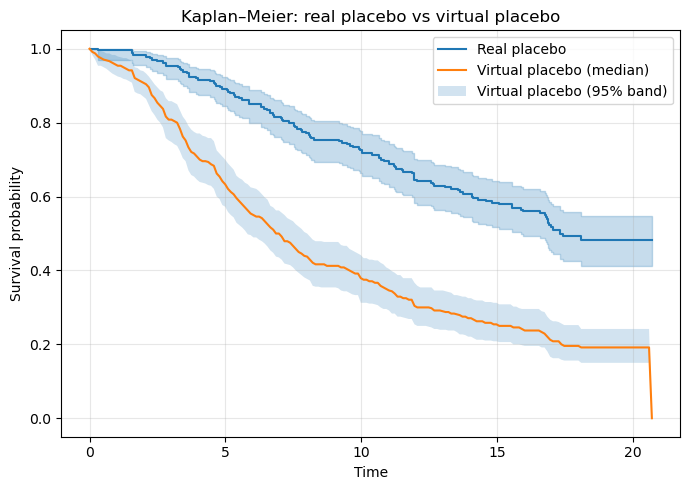

In [74]:
fig, ax = plot_km_overlay_with_virtual_bands_admin(placebo_df=dat_set, var_specs = var_specs_real, n_boot=300, seed=2026)